### Initial package imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.optimize as opt
import datetime as dt
import numpy as np
import sys, re
from statsmodels.distributions.copula.api import CopulaDistribution, GumbelCopula, ClaytonCopula, IndependenceCopula, GaussianCopula, StudentTCopula
from scipy.stats import norm


# Input files

In [34]:
asset_df = pd.read_csv('Data/a3/Data_assignment3.csv', sep=';')
asset_df.set_index('Date', inplace=True)
asset_df = asset_df.loc['4/1/2012':'31/12/2021']

currency_df = asset_df[['EUR/USD', 'EUR/JPY']].copy()

display(currency_df.tail())
display(asset_df.tail())

,EUR/USD,EUR/JPY
Date,,
27/12/2021,1.1325,130.43
28/12/2021,1.1309,130.27
29/12/2021,1.1348,130.82
30/12/2021,1.1323,130.24
31/12/2021,1.1368,131.05


,S&P500,Dax40,Nikkei,EUR/USD,EUR/JPY,Boeing,Airbus,Volkswagen,ASML,NVIDIA,Stellantis,Sony
Date,,,,,,,,,,,,
27/12/2021,4791.19,15835.25,28676.46,1.1325,130.43,203.17,111.5165,264.0,713.1,30.945,16.804,25.442
28/12/2021,4786.35,15963.70,29069.16,1.1309,130.27,206.13,112.5886,265.6,715.3,30.322,16.832,25.496
29/12/2021,4793.06,15852.25,28906.88,1.1348,130.82,203.66,111.2982,260.0,703.5,30.001,16.710,25.338
30/12/2021,4778.73,15884.86,28791.71,1.1323,130.24,202.71,111.8541,259.0,710.4,29.586,16.678,25.184
31/12/2021,4766.18,15884.86,28791.71,1.1368,131.05,201.32,111.5364,259.0,706.7,29.411,16.678,25.280


In [35]:
#create log returns of all columns
currency_df['EUR/USD'] = np.log(currency_df['EUR/USD'] / currency_df['EUR/USD'].shift(1))
currency_df['EUR/JPY'] = np.log(currency_df['EUR/JPY'] / currency_df['EUR/JPY'].shift(1))

#create log returns for all assets in asset_df
asset_df['R_S&P500'] = np.log(asset_df['S&P500'] / asset_df['S&P500'].shift(1))
asset_df['R_Dax40'] = np.log(asset_df['Dax40'] / asset_df['Dax40'].shift(1))
asset_df['R_Nikkei'] = np.log(asset_df['Nikkei'] / asset_df['Nikkei'].shift(1))
asset_df['R_Boeing'] = np.log(asset_df['Boeing'] / asset_df['Boeing'].shift(1))
asset_df['R_Airbus'] = np.log(asset_df['Airbus'] / asset_df['Airbus'].shift(1))
asset_df['R_Volkswagen'] = np.log(asset_df['Volkswagen'] / asset_df['Volkswagen'].shift(1))
asset_df['R_ASML'] = np.log(asset_df['ASML'] / asset_df['ASML'].shift(1))
asset_df['R_NVIDIA'] = np.log(asset_df['NVIDIA'] / asset_df['NVIDIA'].shift(1))
asset_df['R_Stellantis'] = np.log(asset_df['Stellantis'] / asset_df['Stellantis'].shift(1))
asset_df['R_Sony'] = np.log(asset_df['Sony'] / asset_df['Sony'].shift(1))

display(asset_df.head())
asset_df.dropna(inplace=True)


display(currency_df.head())
currency_df.dropna(inplace=True)


,S&P500,Dax40,Nikkei,EUR/USD,EUR/JPY,Boeing,Airbus,Volkswagen,ASML,NVIDIA,...,R_S&P500,R_Dax40,R_Nikkei,R_Boeing,R_Airbus,R_Volkswagen,R_ASML,R_NVIDIA,R_Stellantis,R_Sony
Date,,,,,,,,,,,,,,,,,,,,,
4/1/2012,1277.30,6111.55,8560.11,1.2940,99.26,74.33,24.3204,108.887,41.5584,0.3550,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5/1/2012,1281.06,6095.99,8488.71,1.2780,98.64,73.53,24.3849,112.200,41.3117,0.3678,...,0.002939,-0.002549,-0.008376,-0.010821,0.002649,0.029972,-0.005954,0.035422,-0.025783,-0.028955
6/1/2012,1277.81,6057.92,8390.35,1.2720,97.90,73.98,24.7076,110.715,41.7013,0.3635,...,-0.002540,-0.006265,-0.011655,0.006101,0.013147,-0.013324,0.009387,-0.011760,0.012974,-0.014798
9/1/2012,1280.70,6017.23,8390.35,1.2765,98.05,74.53,24.5835,109.550,42.0779,0.3635,...,0.002259,-0.006739,0.000000,0.007407,-0.005035,-0.010578,0.008990,0.000000,-0.045144,0.001719
10/1/2012,1292.08,6162.98,8422.26,1.2772,98.13,75.00,24.6827,111.982,42.1818,0.3620,...,0.008847,0.023933,0.003796,0.006286,0.004027,0.021957,0.002466,-0.004135,0.054476,0.013080


,EUR/USD,EUR/JPY
Date,,
4/1/2012,NaN,NaN
5/1/2012,-0.012442,-0.006266
6/1/2012,-0.004706,-0.007530
9/1/2012,0.003531,0.001531
10/1/2012,0.000548,0.000816


In [36]:
#corrected returns to EURO
asset_df['C_S&P500'] = (1 + asset_df['R_S&P500']) * (1 + currency_df['EUR/USD']) - 1
asset_df['C_Nikkei'] = (1 + asset_df['R_Nikkei']) * (1 + currency_df['EUR/JPY']) - 1 
asset_df['C_Dax40'] = asset_df['R_Dax40']
asset_df['C_Boeing'] = (1 + asset_df['R_Boeing']) * (1 + currency_df['EUR/USD']) - 1
asset_df['C_Airbus'] = asset_df['R_Airbus']
asset_df['C_Volkswagen'] = asset_df['R_Volkswagen']
asset_df['C_ASML'] = asset_df['R_ASML']
asset_df['C_NVIDIA'] = (1 + asset_df['R_NVIDIA']) * (1 + currency_df['EUR/USD']) - 1
asset_df['C_Stellantis'] = asset_df['R_Stellantis']
asset_df['C_Sony'] = (1 + asset_df['R_Sony']) * (1 + currency_df['EUR/USD']) - 1
asset_df.dropna(inplace=True)

display(asset_df.tail())

,S&P500,Dax40,Nikkei,EUR/USD,EUR/JPY,Boeing,Airbus,Volkswagen,ASML,NVIDIA,...,C_S&P500,C_Nikkei,C_Dax40,C_Boeing,C_Airbus,C_Volkswagen,C_ASML,C_NVIDIA,C_Stellantis,C_Sony
Date,,,,,,,,,,,,,,,,,,,,,
27/12/2021,4791.19,15835.25,28676.46,1.1325,130.43,203.17,111.5165,264.0,713.1,30.945,...,0.014460,0.000823,0.004998,-0.004452,0.005892,-0.011300,0.014407,0.043824,0.023117,0.027413
28/12/2021,4786.35,15963.70,29069.16,1.1309,130.27,206.13,112.5886,265.6,715.3,30.322,...,-0.002423,0.012357,0.008079,0.013030,0.009568,0.006042,0.003080,-0.021723,0.001665,0.000703
29/12/2021,4793.06,15852.25,28906.88,1.1348,130.82,203.66,111.2982,260.0,703.5,30.001,...,0.004848,-0.001409,-0.007006,-0.008654,-0.011527,-0.021310,-0.016634,-0.007237,-0.007274,-0.002795
30/12/2021,4778.73,15884.86,28791.71,1.1323,130.24,202.71,111.8541,259.0,710.4,29.586,...,-0.005193,-0.008418,0.002055,-0.006871,0.004982,-0.003854,0.009760,-0.016104,-0.001917,-0.008288
31/12/2021,4766.18,15884.86,28791.71,1.1368,131.05,201.32,111.5364,259.0,706.7,29.411,...,0.001326,0.006200,0.000000,-0.002942,-0.002844,0.000000,-0.005222,-0.001990,0.000000,0.007786


# Copulas

For the return pairs we have chosen the following:

- Boeing and Airbus
- ASML and NVIDIA
- Volkswagen and Stellantis 


### Fit appropriate marginal distributions

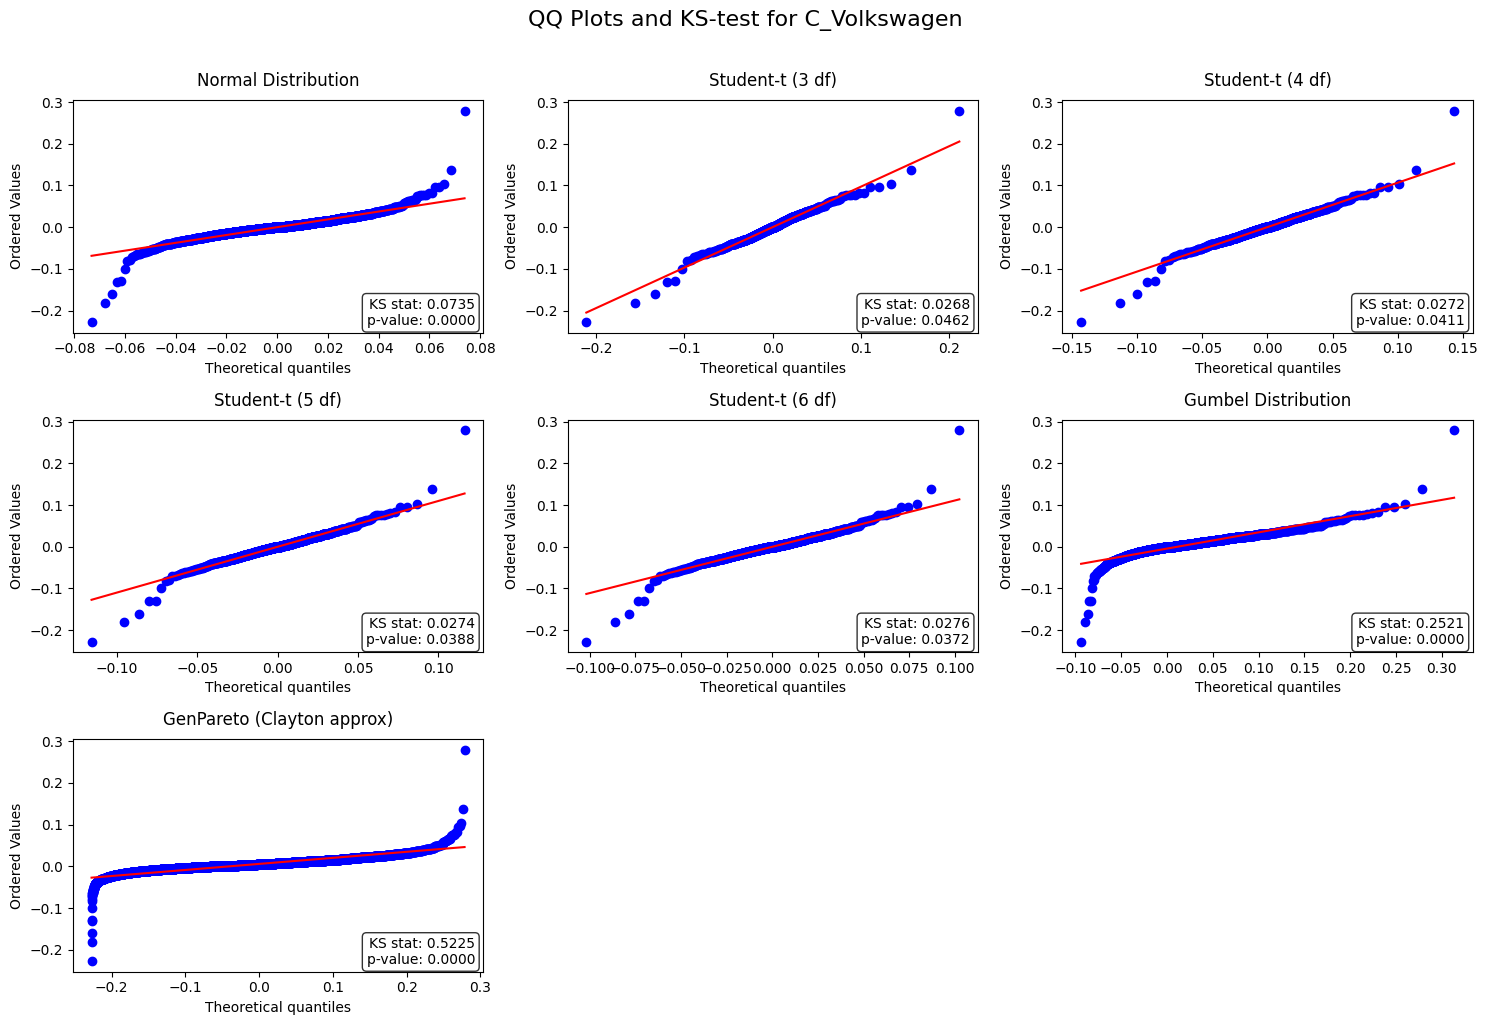

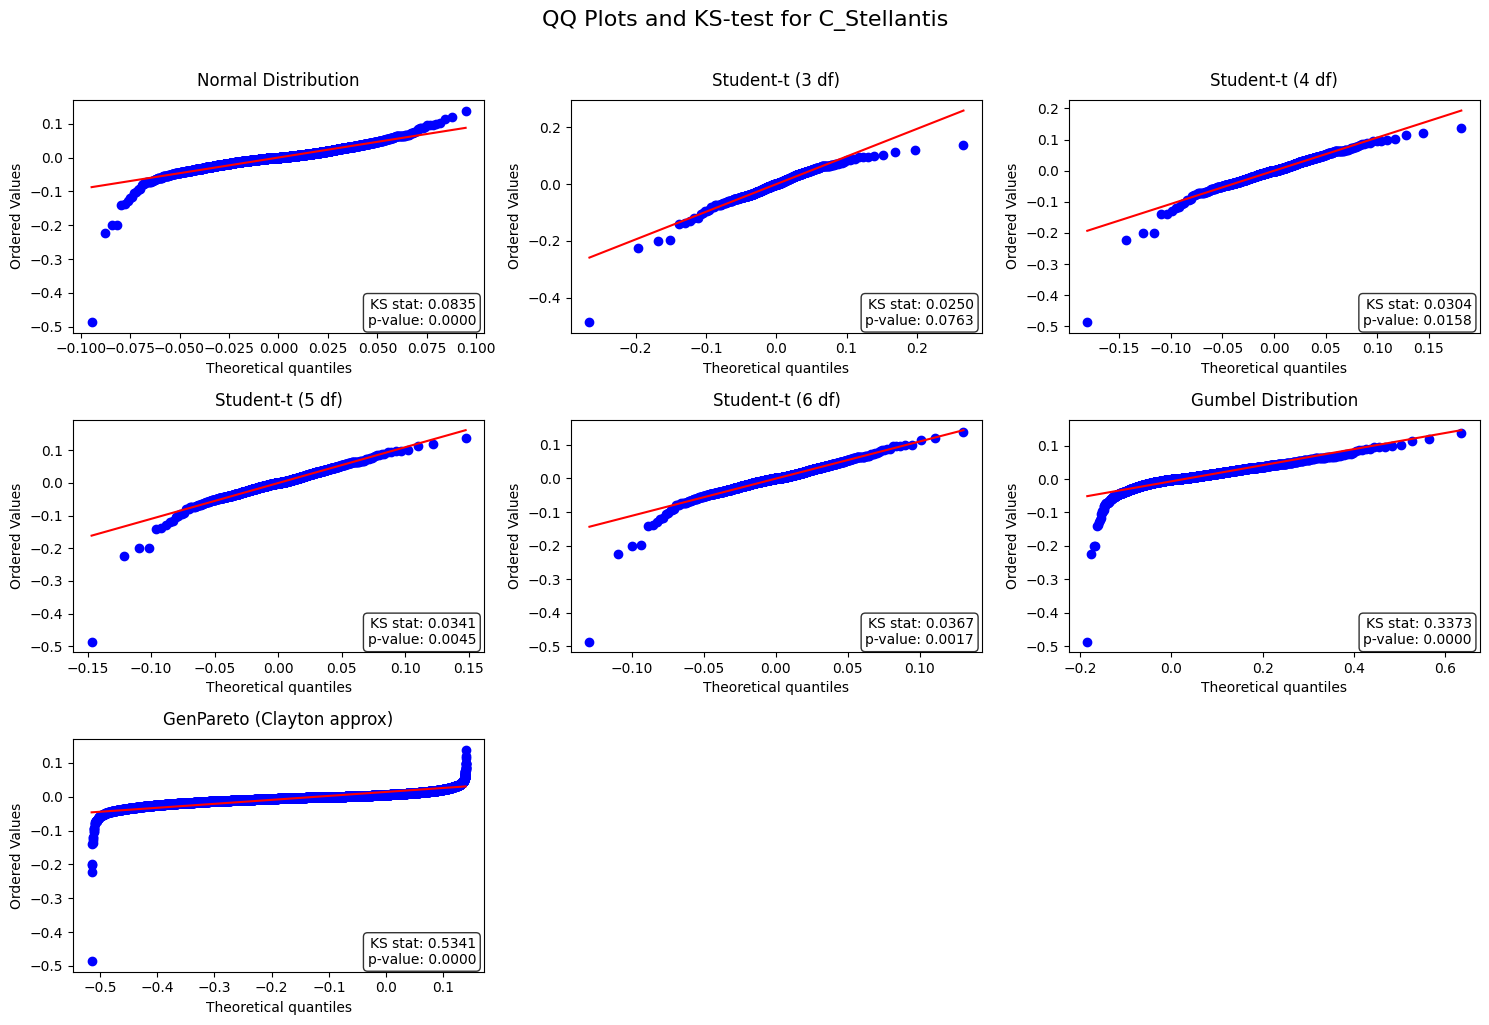

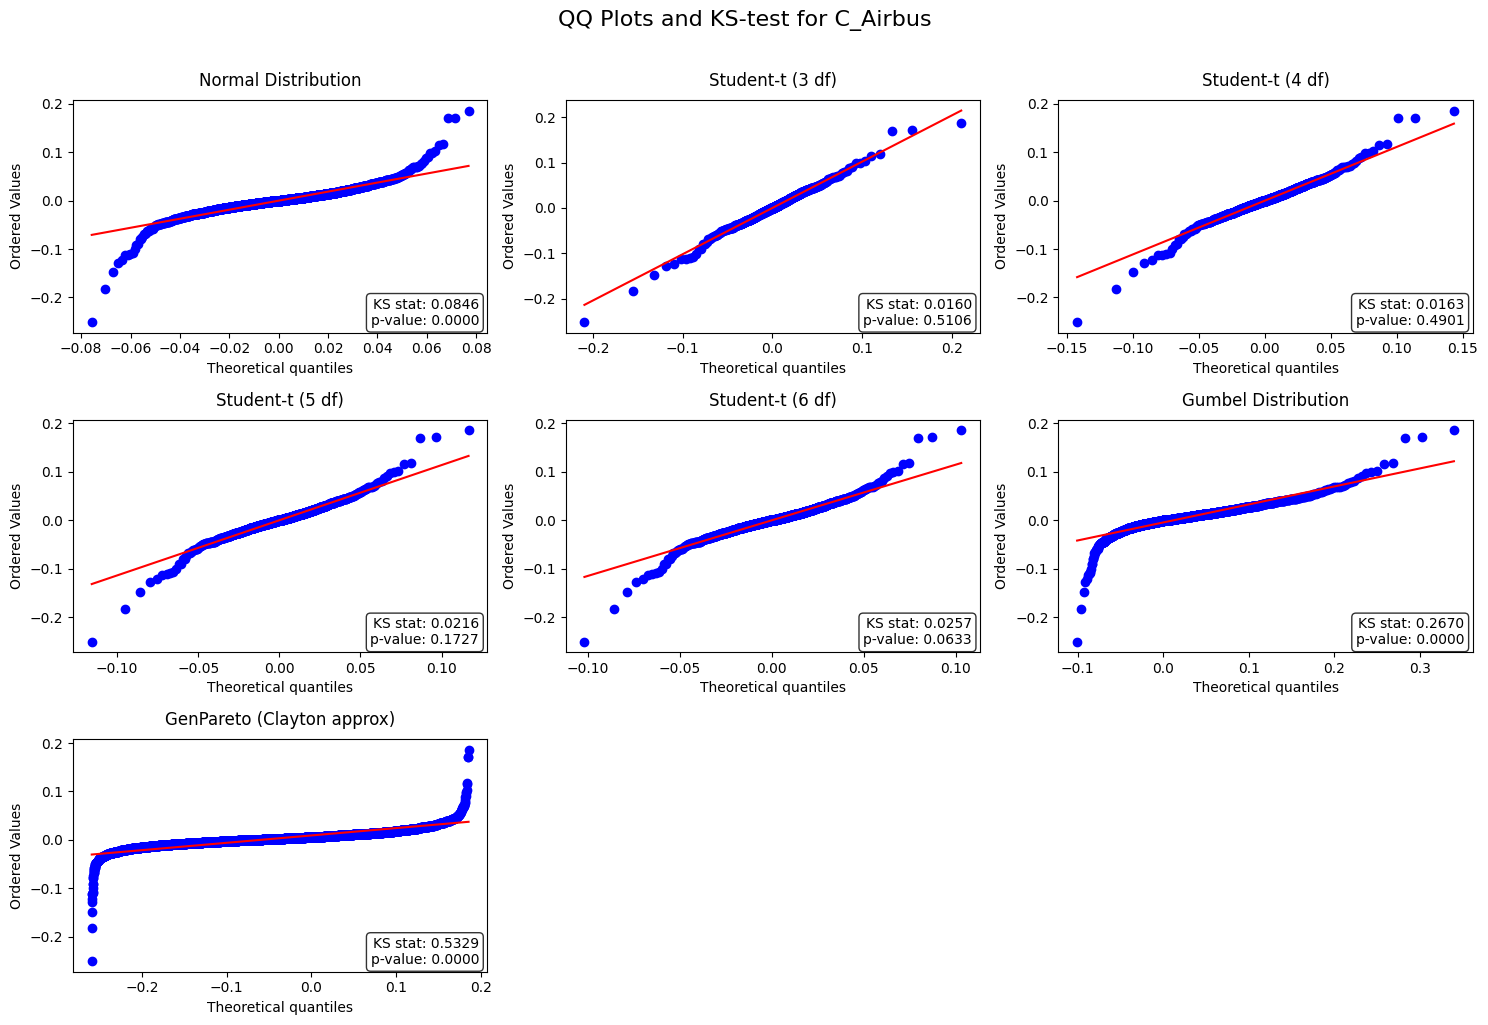

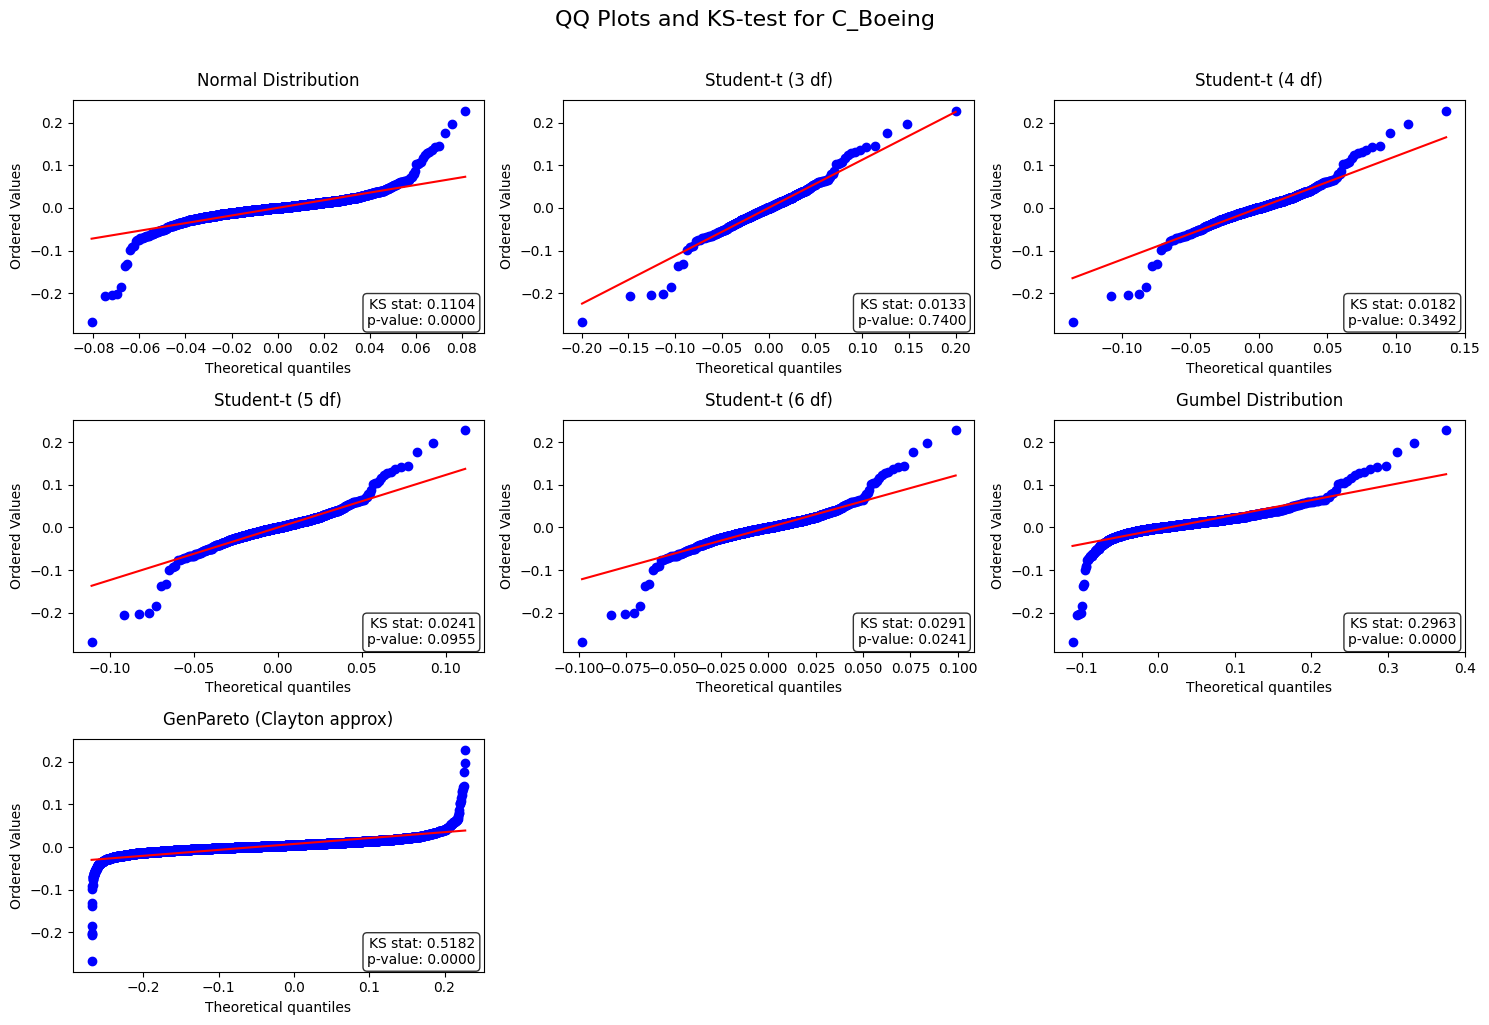

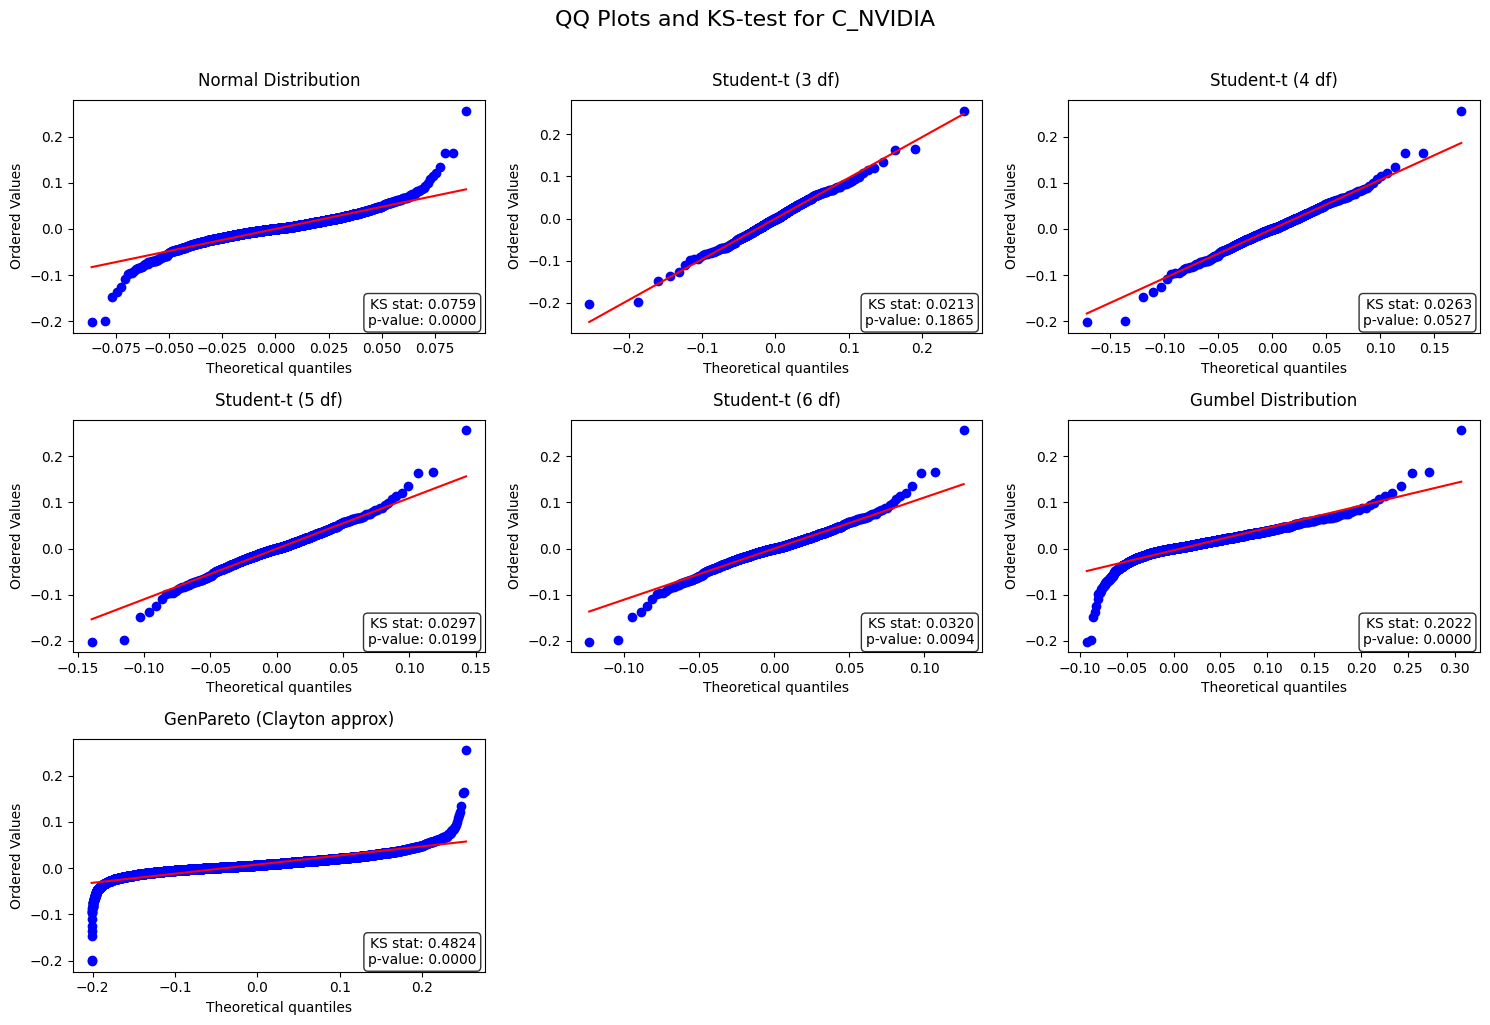

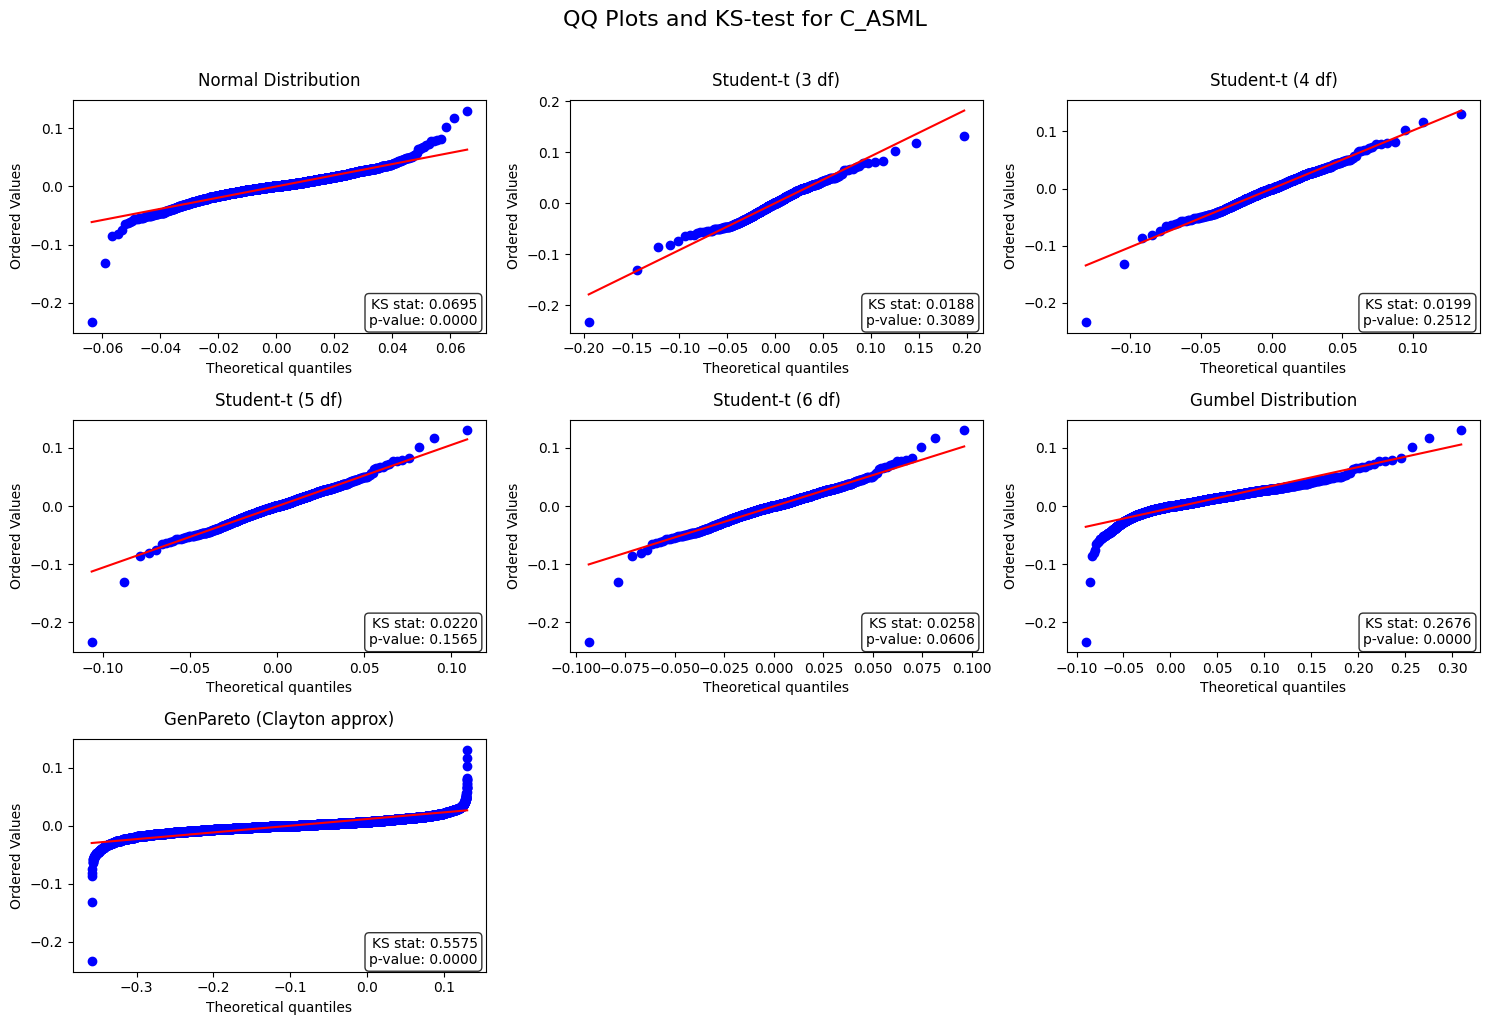

In [37]:
for asset in ['C_Volkswagen', 'C_Stellantis', 'C_Airbus', 'C_Boeing', 'C_NVIDIA', 'C_ASML']:
    fig = plt.figure(figsize=(15, 10))
    plt.suptitle(f'QQ Plots and KS-test for {asset}', fontsize=16, y=1.02)
    
    data = asset_df[asset]

    distributions = [
        (st.norm, 'Normal Distribution', ()),
        (st.t, 'Student-t (3 df)', (3,)),
        (st.t, 'Student-t (4 df)', (4,)),
        (st.t, 'Student-t (5 df)', (5,)),
        (st.t, 'Student-t (6 df)', (6,)),
        (st.gumbel_r, 'Gumbel Distribution', ()),
        (st.genpareto, 'GenPareto (Clayton approx)', ())
    ]
    
    for idx, (dist, title, shape_param) in enumerate(distributions, 1):
        ax = plt.subplot(3, 3, idx)

        if shape_param:
            loc, scale = st.t.fit(data, f0=shape_param[0])[1:]
            sparams = (shape_param[0], loc, scale)
        else:
            params = dist.fit(data)
            sparams = params

        ks_stat, p_value = st.kstest(data, dist.name, args=sparams)

        st.probplot(data, dist=dist, sparams=sparams, plot=plt)
        plt.title(title, pad=10)

        text = f'KS stat: {ks_stat:.4f}\np-value: {p_value:.4f}'
        plt.text(0.98, 0.02, text, transform=ax.transAxes,
                 verticalalignment='bottom', horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()


In [38]:
#create seperate dataframes for each couples with date and closing prices 
df_pair1 = asset_df[['C_Volkswagen','C_Stellantis']]*100
df_pair2 = asset_df[['C_Airbus','C_Boeing']]*100
df_pair3 = asset_df[['C_NVIDIA','C_ASML']]*100

display(df_pair1.head())
display(df_pair2.head())
display(df_pair3.head())

# Drop the rows with value of 0
df_pair1 = df_pair1[(df_pair1 != 0).all(axis=1)]
df_pair2 = df_pair2[(df_pair2 != 0).all(axis=1)]
df_pair3 = df_pair3[(df_pair3 != 0).all(axis=1)]

,C_Volkswagen,C_Stellantis
Date,,
5/1/2012,2.997235,-2.578268
6/1/2012,-1.332366,1.297443
9/1/2012,-1.057827,-4.514447
10/1/2012,2.195708,5.447580
11/1/2012,2.092578,0.231929


,C_Airbus,C_Boeing
Date,,
5/1/2012,0.264858,-2.312836
6/1/2012,1.314680,0.136670
9/1/2012,-0.503540,1.096459
10/1/2012,0.402711,0.683806
11/1/2012,0.661430,-0.887097


,C_NVIDIA,C_ASML
Date,,
5/1/2012,2.253897,-0.595391
6/1/2012,-1.641056,0.938655
9/1/2012,0.353149,0.899036
10/1/2012,-0.358913,0.246619
11/1/2012,-2.539822,0.873566


# Code Bos 

## grad

In [39]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
grad.py

Purpose:
    contain a series of routines used in the
      Principles of Programming for Econometrics
    course at VU/TI Amsterdam

Version:
    1       Extract from ppectr.py, excluding GetCovML()

Date:
    2017/8/21

Author:
    Charles Bos, based partially on Kevin Sheppard's hessian_2sided, with
      ideas/constants from Jurgen Doornik
"""
###########################################################

###########################################################
### vh= _gh_stepsize(vP)
def _gh_stepsize(vP, second= False):
    """
    Purpose:
        Calculate stepsize close (but not too close) to machine precision

    Inputs:
        vP      1D array of parameters

    Return value:
        vh      1D array of step sizes
    """
    vh = 1e-8*(np.fabs(vP)+1e-8)   # Find stepsize
    dRice= 1e-4 if second else 5e-6  # Let stepsize depend on first/second derivatives
    vh= np.maximum(vh, dRice)        # Don't go too small

    return vh

###########################################################
### vG= gradient_2sided(fun, vP, *args)
def gradient_2sided(fun, vP, *args):
    """
    Purpose:
      Compute numerical gradient, using a 2-sided numerical difference

    Author:
      Charles Bos, following Kevin Sheppard's hessian_2sided, with
      ideas/constants from Jurgen Doornik's Num1Derivative

    Inputs:
      fun     function, as used for minimize()
      vP      1D array of size iP of optimal parameters
      args    (optional) extra arguments

    Return value:
      vG      iP vector with gradient

    See also:
      scipy.optimize.approx_fprime, for forward difference
    """
    iP = np.size(vP)
    vP= np.array(vP).reshape(iP)      # Ensure vP is 1D-array

    # f = fun(vP, *args)    # central function value is not needed
    vh= _gh_stepsize(vP)
    mh = np.diag(vh)        # Build a diagonal matrix out of h

    fp = np.zeros(iP)
    fm = np.zeros(iP)
    for i in range(iP):     # Find f(x+h), f(x-h)
        fp[i] = fun(vP+mh[i], *args)
        fm[i] = fun(vP-mh[i], *args)

    vhr = (vP + vh) - vP    # Check for effective stepsize right
    vhl = vP - (vP - vh)    # Check for effective stepsize left
    vG= (fp - fm) / (vhr + vhl)  # Get central gradient

    return vG

###########################################################
### mG= jacobian_2sided(fun, vP, *args)
def jacobian_2sided(fun, vP, *args):
    """
    Purpose:
      Compute numerical jacobian, using a 2-sided numerical difference

    Author:
      Charles Bos, following Kevin Sheppard's hessian_2sided, with
      ideas/constants from Jurgen Doornik's Num1Derivative

    Inputs:
      fun     function, return 1D array of size iN
      vP      1D array of size iP of optimal parameters
      args    (optional) extra arguments

    Return value:
      mG      iN x iP matrix with jacobian

    See also:
      numdifftools.Jacobian(), for similar output
    """
    iP = np.size(vP)
    vP= vP.reshape(iP)      # Ensure vP is 1D-array

    vF = fun(vP, *args)     # evaluate function, only to get size
    iN= vF.size

    vh= _gh_stepsize(vP)
    mh = np.diag(vh)        # Build a diagonal matrix out of h

    mGp = np.zeros((iN, iP))
    mGm = np.zeros((iN, iP))

    for i in range(iP):     # Find f(x+h), f(x-h)
        mGp[:,i] = fun(vP+mh[i], *args)
        mGm[:,i] = fun(vP-mh[i], *args)

    vhr = (vP + vh) - vP    # Check for effective stepsize right
    vhl = vP - (vP - vh)    # Check for effective stepsize left
    mG= (mGp - mGm) / (vhr + vhl)  # Get central jacobian

    return mG

###########################################################
### mH= hessian_2sided(fun, vP, *args)
def hessian_2sided(fun, vP, *args):
    """
    Purpose:
      Compute numerical hessian, using a 2-sided numerical difference

    Author:
      Kevin Sheppard, adapted by Charles Bos

    Source:
      https://www.kevinsheppard.com/Python_for_Econometrics

    Inputs:
      fun     function, as used for minimize()
      vP      1D array of size iP of optimal parameters
      args    (optional) extra arguments

    Return value:
      mH      iP x iP matrix with symmetric hessian
    """
    iP = np.size(vP,0)
    vP= vP.reshape(iP)    # Ensure vP is 1D-array

    f = fun(vP, *args)
    vh= _gh_stepsize(vP, second= True)
    vPh = vP + vh
    vh = vPh - vP

    mh = np.diag(vh)            # Build a diagonal matrix out of vh

    fp = np.zeros(iP)
    fm = np.zeros(iP)
    for i in range(iP):
        fp[i] = fun(vP+mh[i], *args)
        fm[i] = fun(vP-mh[i], *args)

    fpp = np.zeros((iP,iP))
    fmm = np.zeros((iP,iP))
    for i in range(iP):
        for j in range(i,iP):
            fpp[i,j] = fun(vP + mh[i] + mh[j], *args)
            fpp[j,i] = fpp[i,j]
            fmm[i,j] = fun(vP - mh[i] - mh[j], *args)
            fmm[j,i] = fmm[i,j]

    vh = vh.reshape((iP,1))
    mhh = vh @ vh.T             # mhh= h h', outer product of h-vector

    mH = np.zeros((iP,iP))
    for i in range(iP):
        for j in range(i,iP):
            mH[i,j] = (fpp[i,j] - fp[i] - fp[j] + f + f - fm[i] - fm[j] + fmm[i,j])/mhh[i,j]/2
            mH[j,i] = mH[i,j]

    return mH


## readarg

In [40]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
readarg.py

Purpose:
    contain a series of routines for reading command line arguments

Version:
    1       Trying things out
    2       Allowing for a dictionary
    3       Allow for a dictionary argument 'args' which replaces the command line

Date:
    2018/12/10,

Author:
    Charles Bos
"""
#########################################################
### vRes= ReadArg('a', 5, vDef= [1, 2, 3])
### ir= ReadArg({'a': [1, 2, 3])
### val= ReadArg(2)
def ReadArg(sKey, iN= 0, vDef= None, show= False):
    """
    Purpose:
       Read the command line argument, returning a single value with whatever was read, or, when used with a dictionary, checking all the keys in the dictionary

    Inputs:
        sKey        string, label
        iN          integer, size and type indication. 0= boolean, 1= scalar, >1= vector, -1= string, <-1 = list of strings
        vDef        some type, default value
      or
        dtArg       dictionary, keys and default values

    Outputs:
        vRet        vector/list/scalar/boolean. Scalars are of type integer if possible, else float. If label is not found, the default value is returned
      or
        ir          integer, number of keys read from command line arguments
    """
    if (isinstance(sKey, dict)):
        # print ('Going to dict')
        return ReadArg_dict(sKey, show= show)

    lArg= sys.argv
    iA= len(lArg)
    iNa= np.fabs(iN)

    if (isinstance(sKey, int)):
        # val= ReadArg(3);      # Give third command line argument, or None if not found
        if (iA-1 > sKey):
            return lArg[sKey+1]
        return None

    if (iN == 0):
        vRet= (sKey in lArg)
        return vRet


    if (not sKey in lArg):
        return vDef
    j= lArg.index(sKey)+1
    vRet= []
    bCont= (j < iA)
    while bCont:
        if (iN > 0):
            try:
                iElement= float(lArg[j])
                vRet.append(iElement)
            except ValueError:
                print ("Arg '%s' cannot be converted to float" % lArg[j])
                bCont= False
        else:
            iElement= lArg[j]
            vRet.append(iElement)
        j+= 1
        bCont= bCont and (len(vRet) < iNa) and (j < iA)

    if (iN == 1):
        vRet= int(vRet[0]) if ((vRet[0] % 1) == 0) else vRet[0]
    elif (iN == -1):
        vRet= vRet[0]
    elif (iN > 1):
        vRet= np.array(vRet).astype(float)
    # print ("Key '", sKey, "': ", vRet, sep='')
    return vRet

#########################################################
def ReadArg_float(vArg):
    """
    Purpose:
        Read through the string elements in vArg, and transform them to floats if possible

    Inputs:
        vArg    array of length iA, string elements

    Return value:
        vRet    list, floats of elements of first iR elements which can be translated to floats
    """
    vRet= []
    i= 0
    iA= len(vArg)
    while (i < iA):
        try:
            dA= float(vArg[i])
            vRet.append(dA)
            i+= 1
        except ValueError:
            print ("Arg '%s' cannot be converted to float" % vArg[i])
            i= iA
    return vRet

#########################################################
def ReadArg_int(vArg):
    """
    Purpose:
        Read through the string elements in vArg, and transform them to ints if possible

    Inputs:
        vArg    array of length iA, string elements

    Return value:
        vRet    list, ints of elements of first iR elements which can be translated to ints
    """
    vRet= []
    i= 0
    iA= len(vArg)
    while (i < iA):
        try:
            dA= int(vArg[i])
            vRet.append(dA)
            i+= 1
        except ValueError:
            print ("Arg '%s' cannot be converted to int" % vArg[i])
            i= iA
    return vRet

#########################################################
def ReadArg_dict(dtArg, show= False, argv= None):
    """
    Purpose:
       Read the command line argument, filling in the dictionary elements by corresponding elements on the command line.
       So
            dtArg= {'a': 5, 'b': 'hello', 'c': True, 'd': [5, 6, 3], 'e': ['aa', 'bb', 'cc'], 'f': []}
            ir= ReadArg(dtArg)
       should read/check for all those keys. When a list is handed over, readarg should check for all elements until the next keyword? If an empty list is passed, same thing, though then by definition strings are read.

       Note that the routine is NOT finished probably, possibly the whole concept should be set up differently...

    Inputs:
        dtArg       dict, with label and value pairs
        argv        (optional, for debugging) list of arguments, instead of command line arguments

    Outputs:
        dtArg       dict, with values adapted as to the command line arguments

    Return value:
        ir          integer, number of keys found
    """
    lArg= sys.argv if (argv is None) else argv
    # dtArg= {'a': 5, 'b': 'hello', 'c': True, 'd': [5, 6, 3], 'e': ['aa', 'bb', 'cc'], 'f': [], 'args': 'exchange Xetra type depth date 2023-07-03 dir /mnt/etf_calc/tmp/2023-07 isin "IE000JBB8CR7 IE000QDFFK00 IE000SBHVL31 IE000Z8BHG02" label axa xyt whatever redo', 'isin': ''}
    # lArg= ['a', '45', 'hello', 'd', '345', '-2.4', '2.3', 'sdfsf', 'e', 'sdfsa', 'sdfadsfa', 'f', '345', '13', 'df']

    if ('args' in dtArg):
        # lArg= dtArg['args'].split(' ')        # Incorrect, as it splits quoted strings
        # lArg= [p for p in re.split("( |\\\".*?\\\"|'.*?')", dtArg['args']) if p.strip()]          # Correct, but a bit convoluted
        lArg= re.findall(r'[^"\s]\S*|".+?"', dtArg['args'])          # Also correct, simple findall?
        print ('Using arguments:', lArg)

    asK= list(dtArg.keys())
    iK= len(asK)
    iL= len(lArg)


    sK= None
    l0= l1= 0
    dtFound= {}
    while (l0 < iL):
        # print (f'Argument {l0}/{iL}...')
        if (lArg[l0] in asK):
            sK= lArg[l0]
            if isinstance(dtArg[sK], bool):
                l1= l0+1
                # print (f'{type(dtArg[sK])} {sK} at {l0}-{l1}')
            elif isinstance(dtArg[sK], (str, int, float)):
                l1= l0+1+1
                # print (f'{type(dtArg[sK])} {sK} at {l0}-{l1}')
            else:
                l1= l0+len(dtArg[sK])+1
                # print (f'{type(dtArg[sK])} {sK} at {l0}-{l1}')
            l1= min(l1, iL)
            dtFound[sK]= [l0, l1]
            l0= l1
        else:
            l0+= 1

    # print ('lArg: ', lArg)
    # print ('Locations found:', dtFound)

    # Read out the arguments
    # sK= 'a'
    ir= 0
    for sK in asK:
        bFound= (sK in dtFound)
        # print ('key %s, found= %i, arg=' % (sK, bFound), dtArg[sK])
        if (isinstance(dtArg[sK], bool)):
            dtArg[sK]= bFound
            ir+= 1
        elif ((isinstance(dtArg[sK], (list, np.ndarray))) and bFound):
            vLU= dtFound[sK]
            vOrg= dtArg[sK]
            vAns= lArg[vLU[0]+1:vLU[1]]
            bFloat= (len(vOrg) > 0) and isinstance(vOrg[0], float)
            bInt= (len(vOrg) > 0) and isinstance(vOrg[0], int)
            dtArg[sK]= ReadArg_float(vAns) if bFloat else ReadArg_int(vAns) if bInt else vAns
            ir+= 1
        elif (isinstance(dtArg[sK], str) and bFound):
            vLU= dtFound[sK]
            vAns= lArg[vLU[0]+1:vLU[1]]
            dtArg[sK]= vAns[0].strip('"') if (len(vAns)) else ''
            ir+= 1
        elif (isinstance(dtArg[sK], (float, int)) and bFound):
            vLU= dtFound[sK]
            vAns= lArg[vLU[0]+1:vLU[1]]
            dtArg[sK]= ReadArg_float(vAns[0:1])[0] if (len(vAns)) else None
            ir+= 1
        elif (bFound):
            print ('Key %s found, but I do not know what to do with it' % sK)
        # else:
        #     print ('Key %s not found, so not changed' % sK)

    if (show):
        print('ReadArg encountered arguments:')
        for sK in dtArg:
            print ('Key %s(reset=%i):' % (sK, sK in dtFound), dtArg[sK])

    return ir
###########################################################
# def main():
#     # Magic numbers
#     dA= 1000
#     vB= [-1, -1, -1]
#     sS= 'this is the default'
#     tS= ['t1', 't2']

#     dtArg= {'a': dA, 'b': vB, 's': sS, 't': tS}

#     # dtArg['args']= 'a 5.0 b 1 2 3 s hallo t abc def'

#     # Initialisation
#     print ('Usage:\n  ipython readarg.py a 5.0 b 1 2 3 s hallo t abc def')
#     print ('This would read a scalar a, vector b of (max) 3 elements, string s, and list of strings t.')
#     print ('If arguments are not found, default values are filled in, if given')

#     dA= ReadArg('a', 1)            # No default value
#     vB= ReadArg('b', 3, vB)
#     sS= ReadArg('s', -1, sS)
#     tS= ReadArg('t', -2, tS)

#     # Output
#     print (f'A= {dA}', dA)
#     print ('B=\n', vB)
#     print (f's= {sS}', sS)
#     print ('t= ', tS)

#     ir= ReadArg(dtArg, show= True)
#     print ('Using a dictionary: Found %i items, with values \n' % ir, dtArg)



# ###########################################################
# ### start main
# if __name__ == "__main__":
#     main()


## libgas

In [41]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
libGAS.py

Purpose:
    Estimate data from a gas(1,1) model

Version:
    1       First start, following simgas.py
    2       Copy from models/gas/gas.py, adapted for GARCH and use with qfrm

Note:
    The GAS(1,1) corresponds to the GARCH(1,1), with a slight change of parameters.

    If we have
        GARCH:
          S2(t+1)= omega + alpha a(t)^2 + beta S2(t)
        GAS:
          S2(t+1)= O + A s(t) + B S2(t)
    with s(t) the score in the GAS filter, then we have correspondence if
      O = omega
      A = alpha
      B = alpha + beta

Date:
    2019/6/21

Author:
    Charles Bos
"""
###########################################################
### (vY, vS2)= GenrGAS(vP, iT)
def InitialiseGAS(dtArg):
    """
    Purpose:
        Initialise settings, prepare data

    Inputs:
        vP      vector of size 3, with dO, dA, dB
        iT      integer, number of observations

    Return value:
        vY      iT vector, observations
        vS2     iT vector, variances
    """
    ReadArg(dtArg)

    np.random.seed(dtArg['seed'])

    vP0= dtArg['p0']
    iT= dtArg['t']
    (vY, vS20)= GenrGAS(vP0, iT)
    vS2= np.zeros(iT)
    FiltGAS(vS2, vY, vP0)
    print ('Are they again equal?', np.all(vS2 == vS20))

    vL= np.exp(vY/100).cumsum()
    dtD1= dt.datetime.today().date()
    vD= pd.date_range(dtD1- dt.timedelta(days= iT-1), dtD1)

    df= pd.DataFrame(vL, columns= ['y'], index= vD)
    df['Return']= vY
    df['s20']= vS20

    # dtArg['in']= 'data/sim_' + str(df.index[0].year) + '_' + str(df.index[-1].year) 

    if (len(dtArg['d1'])):
        vI= df.index >= dtArg['d1']
        if (vI.sum() > 100):
            df= df[vI]

    dtArg['data']= df
    dtArg['y']= df['Return'].dropna().values
    dtArg['t']= pd.to_datetime(df['Return'].dropna().index)

    # sBase= os.path.basename(dtArg['in'])
    # sSt= sBase.split('_')[0]

    # iY0= dtArg['t'][0].year
    # iY1= dtArg['t'][-1].year
    # dtArg['out']= f'graphs/{sSt}_{iY0}_{iY1}_vol.png'

    return dtArg['y']

###########################################################
### (vY, vS2)= GenrGAS(vP, iT)
def GenrGAS(vP, iT):
    """
    Purpose:
        Generate GAS(1,1) data

    Inputs:
        vP      vector of size 3, with dO, dA, dB
        iT      integer, number of observations

    Return value:
        vY      iT vector, observations
        vS2     iT vector, variances
    """
    (dO, dA, dB)= (vP[0], vP[1], vP[2])
    vY= np.zeros(iT)
    vS2= np.zeros_like(vY)
    dF= dO/(1-dB)
    for i in range(iT):
        vY[i]= np.sqrt(dF) * np.random.randn()
        vS2[i]= dF
        dF= dO + dA*(vY[i]**2 - dF) + dB*dF

    return (vY, vS2)

###########################################################
### vPTr= TransPar(vP)
def TransPar(vP):
    """
    Purpose:
      Transform the parameters for restrictions

    Inputs:
      vP        array of size 3, with parameters O, A, B

    Return value:
      vPTr      array of size 3, with transformed O, A, B
    """
    vPTr= np.copy(vP)
    vPTr[0]= np.log(vP[0])
    vPTr[1:]= np.log(vP[1:]/(1-vP[1:]))

    return vPTr

###########################################################
### vP= TransBackPar(vPTr)
def TransBackPar(vPTr):
    """
    Purpose:
      Transform the parameters back from restrictions

    Inputs:
      vPTr      array of size 3, with transformed O, A, B

    Return value:
      vP        array of size 3, with parameters O, A, B
    """
    vP= np.copy(vPTr)
    vP[0]= np.exp(vPTr[0])
    vP[1:]= np.exp(vPTr[1:])/(1+np.exp(vPTr[1:]))

    return vP

###########################################################
### vPTr= TransPar(vP)
def TransParL(dL):
    """
    Purpose:
      Transform the parameters for restrictions

    Inputs:
      dLambda   double

    Return value:
      dLTr      double, transformed Lambda
    """
    dLTr= np.log(dL/(1-dL))

    return dLTr

###########################################################
### vP= TransBackPar(vPTr)
def TransBackParL(dLTr):
    """
    Purpose:
      Transform the lambda parameters back from restrictions

    Inputs:
      dLTr      double, transformed Lambda

    Return value:
      dLambda   double
    """
    dL= np.exp(dLTr)/(1+np.exp(dLTr))

    return dL

###########################################################
### br= FiltGAS(vS2, vY, vP)
def FiltGAS(vS2, vY, vP):
    """
    Purpose:
        Filter the process using the GAS equations

    Inputs:
        vY      iT vector, observations
        vP      vector of size 3, with dO, dA, dB
        vS2     iT vector, empty space

    Outputs:
        vS2     iT vector, variances

    Return value:
        br      boolean, True if all went well
    """
    iT= vY.shape[0]
    (dO, dA, dB)= (vP[0], vP[1], vP[2])

    dF= dO/(1-dB)
    for i in range(iT):
        vS2[i]= dF

        # ### Check
        # dNabla= -0.5*(1-(vY[i])**2/dF)/dF;
        # dI= 0.5/(dF**2)
        #
        # dS= 1.0 / dI
        # ds= dS * dNabla
        # if (np.fabs(ds - ((vY[i])**2 - dF)) > 1e-5):
        #     print ('i=%i s= %g, salt= %g: ', i, ds, ((vY[i]**2) - dF))

        ds= (vY[i])**2 - dF
        dF= dO + dA * ds + dB * dF

    return not np.any(np.isnan(vS2))

###########################################################
### vLL= LnLGAS(vP, vY)
def LnLGAS(vP, vY):
    """
    Purpose:
        Calculate vector of LL using the GAS equations

    Inputs:
        vP      vector of size 3, with dO, dA, dB
        vY      iT vector, observations


    Return value:
        vLL     iT vector, loglikelihoods
    """
    iT= vY.shape[0]
    vS2= np.zeros_like(vY)

    br= FiltGAS(vS2, vY, vP)
    vLL= st.norm.logpdf(vY/np.sqrt(vS2)) - 0.5*np.log(vS2)

    # vLL0= -0.5*(np.log(2*np.pi) + np.log(vS2) + (vY**2)/vS2)
    # dDiff= np.max(np.abs(vLL - vLL0))
    # print ('ll= %g, diff=%g, o=%g, a=%g, b=%g' % (vLL.mean(), dDiff, vP[0], vP[1], vP[2]))
    # print ('ll= %g, o=%g, a=%g, b=%g' % (vLL.mean(), vP[0], vP[1], vP[2]))

    # vPTr= TransPar(vP)
    # print (f'vP: {vP}, ll: {vLL.sum()}')

    return vLL

###########################################################
### (dLL, vS2, sMess)= EstGAS(vP, vY)
def EstGAS(vP, vY):
    """
    Purpose:
        Optimise GAS model

    Inputs:
        vP      vector of size 3, with dO, dA, dB, starting values
        vY      iT vector, observations

    Outputs:
        vP      3-vector, optimised parameters

    Return value:
        dLL     double, optimal loglikelihood
        vS2     iT vector, time varying variance
        sMess   string, message on convergence
    """
    iT= vY.shape[0]
    vS2= np.zeros(iT)

    # Create function returning NEGATIVE average LL, as function of vP
    AvgNLnLGAS= lambda vP: -(LnLGAS(vP, vY).mean())

    vP0= np.copy(vP)
    print ('In EstGAS')
    res= opt.minimize(AvgNLnLGAS, vP0, method='BFGS')

    vP[:]= res.x
    sMess= res.message
    dLL= -iT*res.fun

    # print ('\nBFGS results in ', sMess, '\nPars: ', vP, '\nLL= ', dLL, ', f-eval= ', res.nfev)

    return (dLL, vS2, sMess)

###########################################################
### (dLL, vS2, sMess)= EstGAS(vP, vY)
def EstGASTr(vP, vY):
    """
    Purpose:
        Optimise GAS model, using transformation

    Inputs:
        vP      vector of size 3, with dO, dA, dB, starting values
        vY      iT vector, observations

    Outputs:
        vP      3-vector, optimised parameters

    Return value:
        dLL     double, optimal loglikelihood
        vS2     iT vector, time varying variance
        sMess   string, message on convergence
    """
    iT= vY.shape[0]
    print ('Hallo')

    # Create function returning NEGATIVE average LL, as function of vP
    AvgNLnLGASTr= lambda vPTr: -(LnLGAS(TransBackPar(vPTr), vY).mean())

    vPTr= TransPar(vP)
    dLL= -iT*AvgNLnLGASTr(vPTr)
    print ('Initial LL=%g in EstGASTr' % dLL)

    res= opt.minimize(AvgNLnLGASTr, vPTr, method='BFGS')

    vP[:]= TransBackPar(res.x)
    sMess= res.message
    dLL= -iT*res.fun
    vS2= np.zeros(iT)
    FiltGAS(vS2, vY, vP)

    # print ('\nBFGS results in ', sMess, '\nPars: ', vP, '\nLL= ', dLL, ', f-eval= ', res.nfev)
    # print(vS2)

    return (dLL, vS2, sMess)



###########################################################
### br= FiltEWMA(vY, dLambda)
def FiltEWMA(vY, dLambda, s20= None):
    """
    Purpose:
        Apply EWMA filter of variance

    Inputs:
        vY          iT vector, observations
        dLambda     double, value for weight
        s20         (optional, default is overall variance) double, initial variance

    Return value:
        vS2     iT vector, time varying variance
    """
    # dLambda= 0.8
    s20= s20 or np.var(vY)

    iT= len(vY)
    vS2= np.zeros_like(vY)
    vS2[0]= s20
    for i in range(0, iT):
        vS2[i]= s20
        s20= dLambda * s20 + (1-dLambda)*(vY[i]**2)

    return vS2



###########################################################
### dD2= AvgEWMAdist(vY, dLambda)
def AvgEWMAdist(vY, dLambda, s20= None):
    """
    Purpose:
        Calculate average misfit of EWMA filter of variance

    Inputs:
        vY          iT vector, observations
        dLambda     double, value for weight

    Return value:
        dD2         double, average difference between vY^2 and vS2
    """
    iT= len(vY)
    vS2= FiltEWMA(vY, dLambda, s20= s20)

    vD= (vY**2) - vS2
    dD2= np.mean(vD**2)

    print (f'l {dLambda}, s20= {s20}, d= {dD2}')

    return dD2

###########################################################
### main
def EstEWMATr(vLambda, vY):
    """
    Purpose:
        Estimate an EWMA filter of variance

    Inputs:
        vY          iT vector, observations
        dLambda0    (optional, default= 0.8) initial value for weight

    Return value:
        dLambda double, optimal weight
        vS2     iT vector, time varying variance
    """
    iT= len(vY)

    # Create function returning average distance to minimize
    AvgEWMAdistLTr= lambda vLTr: np.mean((vY**2 - FiltEWMA(vY, TransBackParL(vLTr)[0]))**2)
    # AvgEWMAdistLTr= lambda vLTr: AvgEWMAdist(vY, TransBackParL(vLTr)[0])

    dLambda0= vLambda[0]
    vLTr= np.array([TransParL(dLambda0)])

    dD= iT*AvgEWMAdistLTr(vLTr)
    print (f'Initial D={dD}')

    res= opt.minimize(AvgEWMAdistLTr, vLTr, method='BFGS')
    dLambda= TransBackParL(res.x)[0]
    sMess= res.message
    dD= iT*res.fun

    vS2= FiltEWMA(vY, dLambda)
    vLambda[0]= dLambda

    print ('\nBFGS results in ', sMess, '\nPars: ', dLambda, '\nD= ', dD, ', f-eval= ', res.nfev)

    return (dD, vS2, sMess)


###########################################################
### main
# def main():
#     # Magic numbers
#     dtArg= {
#              'd1': '05/01/2012',
#              't': 1000,
#              'seed': 1234,
#              'p0': [.1, .05, .95],
#              'l0': .8,
#              'lRM': .94,
#            }

#     # Initialisation
#     vP0= dtArg['p0']
#     vY= InitialiseGAS(dtArg)
#     vT= dtArg['t']
#     # sOut= dtArg['out']

#     # # Estimation
#     # vP= np.copy(vP0)
#     # (dLL, vS2, sMess) = EstGAS(vP, vY)

#     vP= np.copy(vP0)
#     (dLL, vS2, sMess)= EstGASTr(vP, vY)

#     vL0= np.array([dtArg['l0']])
#     (dD, vS2e, sMesse)= EstEWMATr(vL0, vY)
#     vS2rm= FiltEWMA(vY, dtArg['lRM'])

#     # Output

#     plt.figure(figsize= (8, 4))
#     ax= plt.subplot(1, 2, 1)
#     plt.plot(vT, vY, 'b.', label='y')
#     if ('s20' in dtArg):
#         plt.plot(vT, -np.sqrt(dtArg['s20']), 'g-', label='Generated sdev')
#     plt.plot(vT, 2*np.sqrt(vS2), 'r-', label='Volatility GARCH')
#     plt.plot(vT, 2*np.sqrt(vS2e), 'g-', label=f'Volatility EWMA(l={vL0[0]:.2f})')
#     plt.plot(vT, 2*np.sqrt(vS2rm), 'y-', label=f'Volatility EWMA(lRM={dtArg["lRM"]})')

#     plt.plot(vT, -2*np.sqrt(vS2), 'r-')
#     plt.plot(vT, -2*np.sqrt(vS2e), 'g-')
#     plt.plot(vT, -2*np.sqrt(vS2rm), 'y-')

#     fmTime = mdates.DateFormatter('%y')
#     ax.xaxis.set_major_formatter(fmTime)

#     plt.legend()

#     ax= plt.subplot(1, 2, 2)
#     plt.plot(vT, np.sqrt(vS2), 'r-', label='Volatility GARCH')
#     plt.plot(vT, np.sqrt(vS2e), 'g-', label=f'Volatility EWMA(l={vL0[0]:.2f})')
#     plt.plot(vT, np.sqrt(vS2rm), 'y-', label=f'Volatility EWMA(lRM={dtArg["lRM"]})')
#     ax.xaxis.set_major_formatter(fmTime)

#     # plt.legend()
#     plt.show()

# ###########################################################
# ### start main
# if __name__ == '__main__':
#     main()


## estcop4

In [46]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
EstCOP.py

Purpose:
    Estimate copula

Version:
    1       First start, based on l2/estgas.py
    2       Include Gumbel/Clayton copula estimation
    3       Trying to get Gumbel working right...
    4       Cleaning out checking code

Note:
    The GAS(1,1) corresponds to the GARCH(1,1), with a slight change of parameters.

    If we have
        GARCH:
          S2(t+1)= omega + alpha a(t)^2 + beta S2(t)
        GAS:
          S2(t+1)= O + A s(t) + B S2(t)
    with s(t) the score in the GAS filter, then we have correspondence if
      O = omega
      A = alpha
      B = alpha + beta

Date:
    2019/6/21, 2025/3/20

Author:
    Charles Bos
"""
###########################################################
### (vY, vS2)= GenrGAS(vP, iT)
def Initialise(dtArg, pair):
    """
    Purpose:
        Initialise settings, prepare data

    Inputs:
        vP      vector of size 3, with dO, dA, dB
        iT      integer, number of observations

    Return value:
        vY      iT vector, observations
        vS2     iT vector, variances
    """    
    #ReadArg(dtArg)

    # assume dtArg already exists and ReadArg(dtArg) has been called if needed

    df = pair.copy()
    df = df.dropna()
    dtArg['data.df'] = df
    cols = df.columns.tolist()
    dtArg['vars'] = cols
    dtArg['tickers'] = [c.replace('C_', '') for c in cols]
    dtArg['y'] = df[ cols ].values
    dtArg['t'] = df.index.to_numpy()

    return df

def EstimMargin(dtArg):
    """
    Purpose:
        Estimate GARCH-Normal margins on the variables of interest

    Inputs:
        dtArg   dictionary, settings with df_pair1, vars

    Outputs:
        dtArg   dictionary, with res.df with parameter estimates, and df_pair1 updated with S2 and U
    """
    vP0= dtArg['p0']
    df= dtArg['data.df']
    avP= []
    for r in dtArg['vars']:
        vP= np.copy(vP0)
        vY= df[r].values
        dM= vY.mean()
        print (f'\n=====\nEstimating model for "{r}"')
        (dLL, vS2, sMess)= EstGASTr(vP, vY-dM)
        df[ 'S2' + r[1:]]= vS2
        vU= st.norm.cdf((vY-dM) / np.sqrt(vS2))
        df[ 'U' + r[1:]]= vU

        avP.append(vP)
    dtArg['res.df']= pd.DataFrame(avP, index= dtArg['vars'], columns= ['O', 'A', 'B'])

###########################################################
### main

def DisplayDF(dtArg):
    """
    Purpose:
        Display the output of the margin estimation
    """
    df = dtArg['data.df']
    vars_ = dtArg['vars']     
    tickers = dtArg['tickers']  

    # Ensure datetime index
    if df.index.dtype != 'datetime64[ns]':
        df.index = pd.to_datetime(df.index, format='%d/%m/%Y')

    U_vars = ['U' + v[1:] for v in vars_]
    fmTime = mdates.DateFormatter('%Y')
    locator = mdates.AutoDateLocator()

    # Create main figure
    plt.figure(figsize=(15,10))

    # 1) Raw returns plot (1,1)
    ax = plt.subplot(2,3,1)
    ax.plot(df[vars_])
    ax.legend(tickers)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(fmTime)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    # 2) Returns±2σ plots (1,2) and (2,2)
    for i, var in enumerate(vars_):
        ax = plt.subplot(2,3,2+i*3)
        ax.plot(df[var], '.', label=tickers[i])
        ax.plot(2*np.sqrt(df['S2' + var[1:]]), 'r-')
        ax.plot(-2*np.sqrt(df['S2' + var[1:]]), 'r-')
        ax.legend()
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(fmTime)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    # 3) U-transform plots (1,3) and (2,3)
    for i, Uvar in enumerate(U_vars):
        ax = plt.subplot(2,3,3+i*3)
        ax.plot(df[Uvar], '.', label=tickers[i])
        ax.legend()
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(fmTime)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    # 4) U scatter plot (2,1)
    ax = plt.subplot(2,3,4)
    ax.plot(df[U_vars[0]], df[U_vars[1]], '.', label='U(GARCH)')
    ax.set_xlabel(tickers[0])
    ax.set_ylabel(tickers[1])
    ax.legend()

    plt.tight_layout()
    plt.show()

    # 5) Final separate U vs U scatter
    plt.figure(figsize=(6,6))
    ax = plt.gca()
    ax.plot(df[U_vars[0]], df[U_vars[1]], '.')
    ax.set_xlabel(tickers[0])
    ax.set_ylabel(tickers[1])
    plt.show()

###########################################################
###vPTr= TransPar(vP, mod= 'gauss')
def TransParC(vP, mod= 'gauss'):
    """
    Purpose:
      Transform the parameters for restrictions

    Inputs:
      vP        array of size 1 or 2, with parameters rho and nu, or theta

    Return value:
      vPTr      array, with transformed rho and nu, or theta
    """
    vPTr= np.copy(vP)
    if (mod in ['gauss', 'stud']):
        vPTr[0]= np.log(vP[0]/(1-vP[0]))
        if (len(vPTr) > 1):
            vPTr[1]= np.log(vP[1]-2)
    else:
        dLim= -1 if mod.startswith('clayton') else 1
        vPTr[0]= np.log(vPTr[0] - dLim)

    return vPTr

###########################################################
###vP= TransBackPar(vPTr)
def TransBackParC(vPTr, mod= 'gauss'):
    """
    Purpose:
      Transform the parameters back from restrictions

    Inputs:
      vPTr      array, with transformed rho and nu, or theta

    Return value:
      vP        array of size 1 or 2, with parameters rho and nu, or theta
    """
    vP= np.copy(vPTr)
    if (mod in ['gauss', 'stud']):
        vP[0]= np.exp(vPTr[0])/(1+np.exp(vPTr[0]))
        if (len(vP) > 1):
            vP[1]= 2+np.exp(vPTr[1])
    else:
        dLim= -1 if mod.startswith('clayton') else 1
        vP[0]= dLim+np.exp(vPTr[0])

    return vP

###########################################################
### vLL= LnLCopExpl(vP, mU, mod= 'clayton')
def LnLCopExplSM(vP, mU, mod= 'gumbelSM'):
    """
    Purpose:
        Calculate the loglikelihood according to the explicit copula density, through statsmodels
    """
    # vP= TransBackParC(vPTr, mod= mod)
    iT= mU.shape[0]
    dTheta= vP[0]

    if (mod == 'gumbelSM'):
        copula= GumbelCopula(theta= dTheta)
    else:
        copula= ClaytonCopula(theta= dTheta)
    vLL= copula.logpdf(mU)

    return vLL

###########################################################
### vLL= LnLCopExpl(vP, mU, mod= 'clayton')
def LnLCopExpl(vP, mU, mod= 'gumbel'):
    """
    Purpose:
        Calculate the loglikelihood according to the explicit copula density
    """
    # vP= TransBackParC(vPTr, mod= mod)
    iT= mU.shape[0]
    dTheta= vP[0]
    if (mod == 'gumbel'):
        # Generator
        fnPsi= lambda t: np.exp(-t**(1/dTheta))
        # First derivative of generator
        fnpsi= lambda t: -t**(1/dTheta-1) * fnPsi(t) / dTheta
        # Second derivative of generator
        fnpsi2= lambda t: t**(1/dTheta-2) * (-1 + dTheta + t**(1/dTheta)) * fnPsi(t) / dTheta**2

        # Inverse generator x(u)
        fnPsiI= lambda u: (-np.log(u))**dTheta
        # First derivative of inverse generator x(u)
        fnpsiI= lambda u: -dTheta*(-np.log(u))**(dTheta-1) / u
    elif (mod == 'clayton'):
        # Generator
        fnPsi= lambda t: (1+dTheta*t)**(-1/dTheta)
        # First derivative of generator
        fnpsi= lambda t: -(1+dTheta*t)**(-1/dTheta-1)
        # Second derivative of generator
        fnpsi2= lambda t: (1+dTheta)*(1+dTheta*t)**(-1/dTheta-2)

        # Inverse generator x(u)
        fnPsiI= lambda u: (u**(-dTheta) - 1)/dTheta
        # First derivative of inverse generator x(u)
        fnpsiI= lambda u: -u**(-dTheta-1)
    else:
        print (f'Error: Model {mod} not recognised')
        return np.nan

    # Get the loglikelihood
    mX= fnPsiI(mU)
    vX= mX.sum(axis= 1)
    vL= fnpsi2(vX)*fnpsiI(mU).prod(axis= 1)

    vLL= np.log(vL)

    print (f'l: {vLL.sum():.4f}, th: {dTheta:.4f}')
    if (len(vLL) != iT):
        print (f'Error: shape of vLL= {vLL.shape}, should be ({iT},)')

    return vLL

###########################################################
### vLL= LnLCopImpl(vP, mU, mod= 'stud')
def LnLCopImpl(vP, mU, mod= 'gauss'):
    """
    Purpose:
        Calculate vector of LL using the Copula equations

    Inputs:
        vP      vector of size 1 or 2, with dRho, dNu
        mU      iT x 2 matrix, observations


    Return value:
        vLL     iT vector, loglikelihoods
    """
    if (mod == 'gauss'):
        dNu= np.inf
        fnf= st.norm()
    elif (mod == 'stud'):
        dNu= vP[1]
        fnf= st.t(dNu)
    else:
        print (f'Error: Model {mod} not recognised')
        return np.nan

    iT= mU.shape[0]
    dRho= vP[0]
    mP= np.array([[1, dRho], [dRho, 1]])
    mC= np.linalg.cholesky(mP)
    mCi= np.linalg.inv(mC)
    (iS, dLogD)= np.linalg.slogdet(mP)

    mX= fnf.ppf(mU)
    vF= fnf.logpdf(mCi@mX.T).sum(axis= 0) - 0.5*dLogD
    vG= fnf.logpdf(mX.T).sum(axis= 0)
    vLL= vF - vG

    if (len(vLL) != iT):
        print (f'Error: shape of vLL= {vLL.shape}, should be ({iT},)')

    return vLL

###########################################################
### vLL= LnLGAS(vP, mU)
def LnLCop(vP, mU, mod= 'gauss'):
    """
    Purpose:
        Calculate vector of LL using the Copula equations

    Inputs:
        vP      vector of size 1 or 2, with dRho, dNu, or theta
        mU      iT x 2 matrix, observations

    Return value:
        vLL     iT vector, loglikelihoods
    """
    if (mod in ['gumbel', 'clayton']):
        return LnLCopExpl(vP, mU, mod= mod)
    if (mod in ['gumbelSM', 'claytonSM']):
        return LnLCopExplSM(vP, mU, mod= mod)
    return LnLCopImpl(vP, mU, mod= mod)

###########################################################
### main
def EstCopula(dtArg, mod= 'gauss'):
    # mod= 'gumbel'
    df= dtArg['data.df']
    asTick = dtArg['tickers']
    asU = ['U_' + t for t in asTick]
    mU = df[asU]

    iT= mU.shape[0]

    # mR= mU.rank()
    mR= mU          # No need to take the ranks, scipy.stats will take those
    res= st.kendalltau(mR.iloc[:, 0], mR.iloc[:,1])
    dRtau= res.statistic
    if (mod in ['gauss', 'stud']):
        mP0= mU.corr()
        dP0= mP0.iloc[0, 1]
        dNu= 3.0
    elif (mod.startswith('gumbel')):
        dP0= 1/(1-dRtau)
    else:
        res= st.spearmanr(mU)
        dRsp= res.statistic
        # dP0= dRsp  #### Huh??? 2 keer een andere assignment waarde
        dP0= 2*dRtau/(1-dRtau)
    vP0= np.array([dP0, dNu]) if mod == 'stud' else np.array([dP0])

    # Create function returning NEGATIVE average LL, as function of vP
    AvgNLnLCopTr= lambda vPTr: -(LnLCop(TransBackParC(vPTr, mod= mod), mU, mod= mod).mean())

    vPTr= TransParC(vP0, mod= mod)
    # dALnL= AvgNLnLCopTr(vPTr)
    res= opt.minimize(AvgNLnLCopTr, vPTr, method='BFGS')

    vP= TransBackParC(res.x, mod= mod)
    sMess= res.message
    dLL= -iT*res.fun

    print ('\nBFGS results in ', sMess, '\nPars: ', vP, '\nLL= ', dLL, ', f-eval= ', res.nfev)

    # LnLCopL= lambda x: -(LnLCop([x], mU, mod= mod).mean())
    # vT= np.arange(1, 3, .01)
    # vL= [ LnLCopL(t) for t in vT ]
    return (dLL, vP, sMess)

def plot_copula_contours(dtArg, dfR):
    df = dtArg['data.df']
    tickers = dtArg['tickers']
    U = df[['U_' + t for t in tickers]].values
    
    # grid for (u,v)
    grid = np.linspace(0.01, 0.99, 50)
    U1, U2 = np.meshgrid(grid, grid)
    uv = np.column_stack([U1.ravel(), U2.ravel()])

    # define models to plot
    models = {
        'Gaussian': (GaussianCopula(corr=dfR.loc['Rho','Norm']), norm, norm),
        'Student-t': (StudentTCopula(corr=dfR.loc['Rho','t'], 
                                   df=dfR.loc['Nu','t']), norm, norm),
        'Gumbel': (GumbelCopula(theta=dfR.loc['Theta','gumbel']), norm, norm),
        'Clayton': (ClaytonCopula(theta=dfR.loc['Theta','clayton']), norm, norm),
    }

    # Create single figure with 4 subplots side by side
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    for (ax, (name, (cop, m1, m2))) in zip(axes, models.items()):
        cop_dist = CopulaDistribution(copula=cop,
                                    marginals=[m1(), m2()])
        Z = cop_dist.pdf(uv).reshape(U1.shape)

        ax.contour(U1, U2, Z, levels=8)
        ax.scatter(U[:,0], U[:,1], s=5, alpha=0.6)
        ax.set_title(f'{name} copula fit')
        ax.set_xlabel('U₁')
        ax.set_ylabel('U₂')

    plt.tight_layout()
    plt.show()

def frechet_bounds(u, v):
    """
    Compute the Fréchet–Hoeffding lower (W) and upper (M) bounds
    for two arrays of U(0,1) observations.
    """
    u = np.asarray(u)
    v = np.asarray(v)
    W = np.maximum(u + v - 1, 0.0)
    M = np.minimum(u, v)
    return W, M

###########################################################
## main
def main(pair):
    # ─── 1) Magic numbers ─────────────────────────────────────────────────────
    dtArg = {
        'd1':  '5/1/2012',
        'p0':  [.1, .05, .95],
        'l0':  .8,
        'lRM': .94,
    }

# Initialisation
    df= Initialise(dtArg, pair)

    # Estimation
    EstimMargin(dtArg)

    asTick= dtArg['tickers']

    asU= ['U_' + t for t in asTick]
    mU= df[asU]
    mP0= mU.corr()
    dRho0= mP0.iloc[0, 1]

    # mR= mU.rank()
    mR= mU          # No need to take the ranks, scipy.stats will take those
    res= st.kendalltau(mR.iloc[:, 0], mR.iloc[:,1])
    dRtau= res.statistic
    dThetaGu= 1/(1-dRtau)
    dThetaCl= 2*dRtau/(1-dRtau)

    res= st.spearmanr(mU)
    dRsp= res.statistic

    print("Kendall's tau =", dRtau)
    print("Spearman's rho =", dRsp)
    # …or, in the Spearman branch…

    print(df[asU])

    dfR= pd.DataFrame(index= ['Rho', 'Nu', 'Theta', 'LL'])
    dfR.loc['Rho', 'Corr']= dRho0

    (dLLn, vPn, sMessn)= EstCopula(dtArg, mod= 'gauss')
    dfR.loc['Rho', 'Norm']= vPn
    dfR.loc['LL', 'Norm']= dLLn

    (dLLt, vPt, sMesst)= EstCopula(dtArg, mod= 'stud')
    dfR.loc[['Rho', 'Nu'], 't']= vPt
    dfR.loc['LL', 't']= dLLt

    dfR.loc['Theta', 'GuTau']= dThetaGu
    (dLLg, vPg, sMessg)= EstCopula(dtArg, mod= 'gumbel')
    dfR.loc['Theta', 'gumbel']= vPg
    dfR.loc['LL', 'gumbel']= dLLg

    (dLLg, vPg, sMessg)= EstCopula(dtArg, mod= 'gumbelSM')
    dfR.loc['Theta', 'gumbelSM']= vPg
    dfR.loc['LL', 'gumbelSM']= dLLg

    dfR.loc['Theta', 'ClTau']= dThetaCl
    (dLLc, vPc, sMessc)= EstCopula(dtArg, mod= 'clayton')
    dfR.loc['Theta', 'clayton']= vPc
    dfR.loc['LL', 'clayton']= dLLc

    (dLLc, vPc, sMessc)= EstCopula(dtArg, mod= 'claytonSM')
    dfR.loc['Theta', 'claytonSM']= vPc
    dfR.loc['LL', 'claytonSM']= dLLc


    
    plot_copula_contours(dtArg, dfR)

    # Output
    DisplayDF(dtArg)

    print ('Estimation results:')
    print (dfR.iloc[:, :3].dropna(axis= 0, how= 'all').to_latex(float_format= '%.3f'))
    print (dfR.iloc[:, 3:].dropna(axis= 0, how= 'all').to_latex(float_format= '%.3f'))

###########################################################




=====
Estimating model for "C_Volkswagen"
Hallo
Initial LL=-5066.65 in EstGASTr

=====
Estimating model for "C_Stellantis"
Hallo
Initial LL=-6216.17 in EstGASTr
Kendall's tau = 0.3784306272987641
Spearman's rho = 0.5344659515430561
            U_Volkswagen  U_Stellantis
Date                                  
5/1/2012        0.913449      0.313479
6/1/2012        0.276994      0.611059
9/1/2012        0.309525      0.117614
10/1/2012       0.851989      0.906593
11/1/2012       0.838173      0.519179
...                  ...           ...
23/12/2021      0.907850      0.596040
27/12/2021      0.328862      0.823513
28/12/2021      0.592246      0.524687
29/12/2021      0.170609      0.370753
30/12/2021      0.426569      0.461018

[2469 rows x 2 columns]

BFGS results in  Optimization terminated successfully. 
Pars:  [0.48284907] 
LL=  329.3009716081141 , f-eval=  12

BFGS results in  Optimization terminated successfully. 
Pars:  [ 0.51723072 49.28332206] 
LL=  350.3791578263628 , f-ev

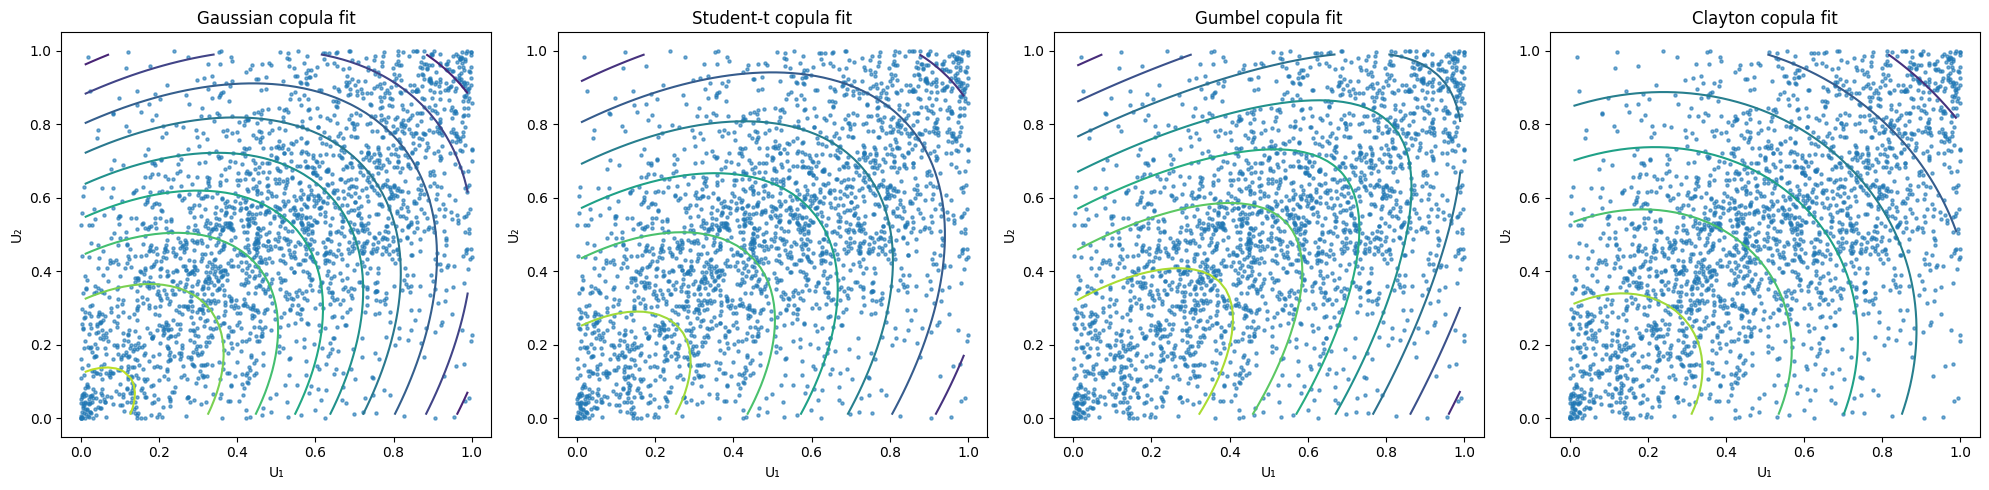

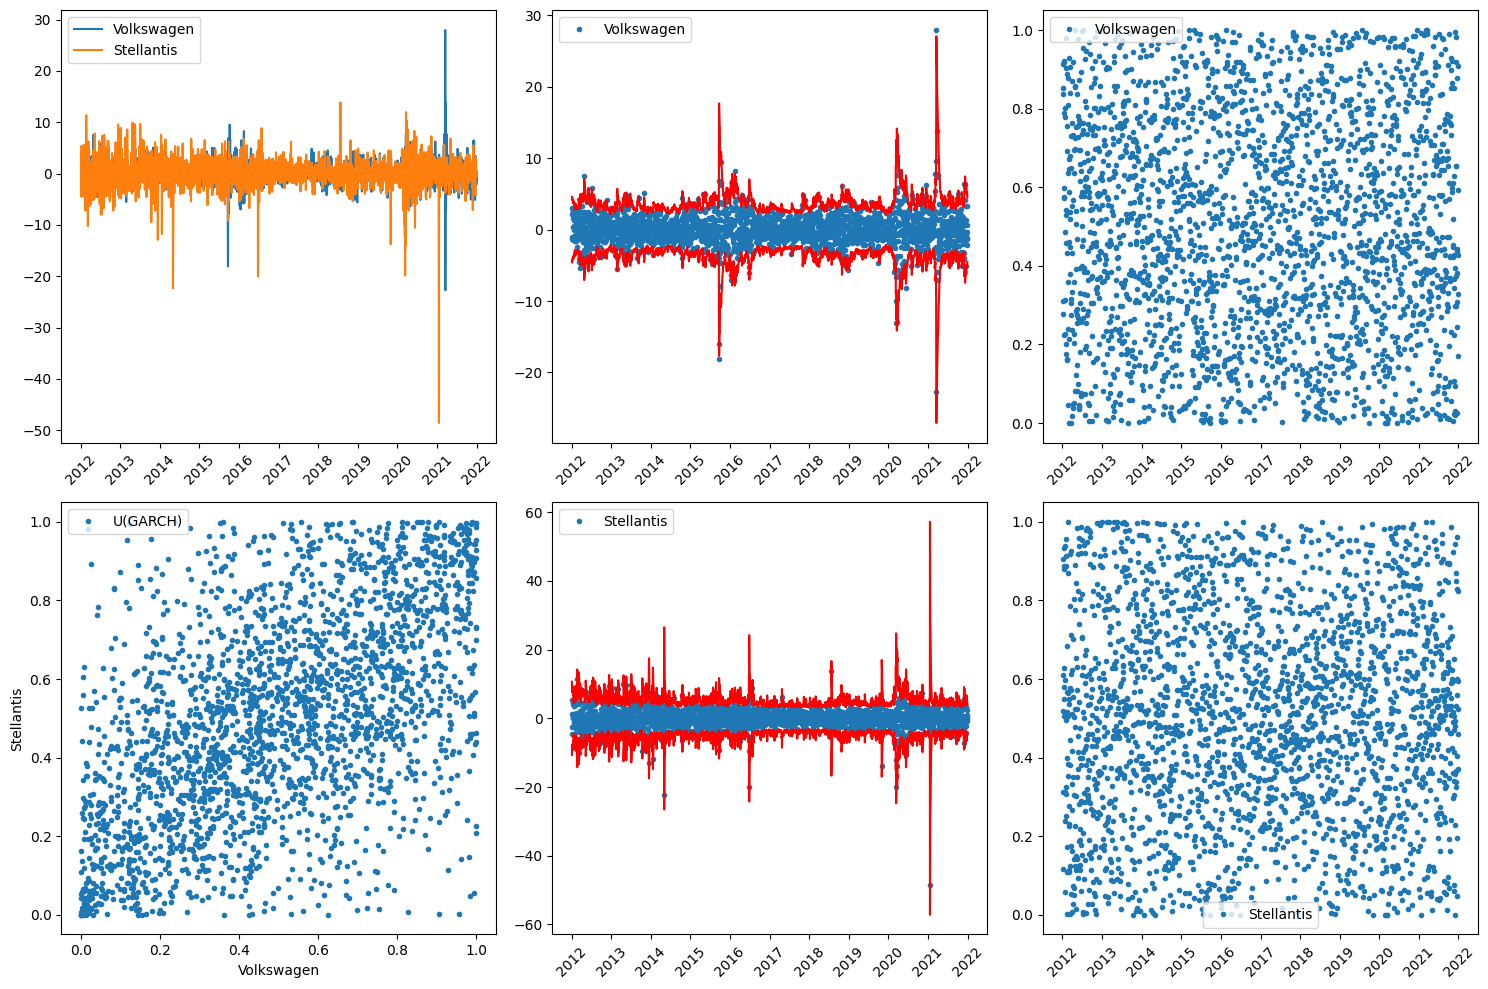

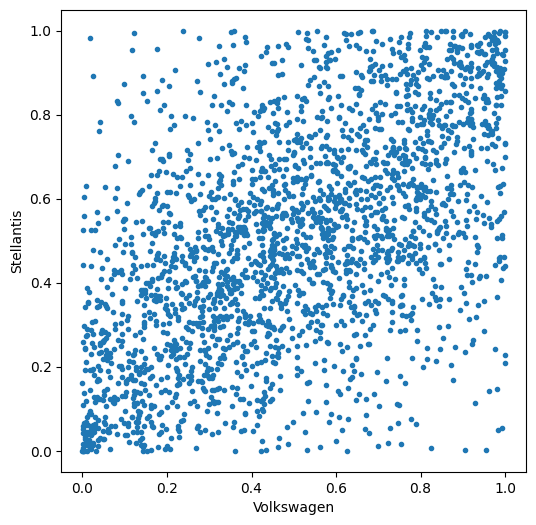

Estimation results:
\begin{tabular}{lrrr}
\toprule
 & Corr & Norm & t \\
\midrule
Rho & 0.538 & 0.483 & 0.517 \\
Nu & NaN & NaN & 49.283 \\
LL & NaN & 329.301 & 350.379 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrr}
\toprule
 & GuTau & gumbel & gumbelSM & ClTau & clayton & claytonSM \\
\midrule
Theta & 1.609 & 1.503 & 1.503 & 1.218 & 0.539 & 0.539 \\
LL & NaN & 315.985 & 315.985 & NaN & 185.595 & 185.595 \\
\bottomrule
\end{tabular}



In [47]:
main(df_pair1)


=====
Estimating model for "C_Airbus"
Hallo
Initial LL=-5298.67 in EstGASTr

=====
Estimating model for "C_Boeing"
Hallo
Initial LL=-5056.26 in EstGASTr
Kendall's tau = 0.09330135204922879
Spearman's rho = 0.1378307376771553
            U_Airbus  U_Boeing
Date                          
5/1/2012    0.539704  0.110167
6/1/2012    0.741372  0.519689
9/1/2012    0.382128  0.715163
10/1/2012   0.575174  0.640401
11/1/2012   0.636102  0.294107
...              ...       ...
27/12/2021  0.587920  0.418877
28/12/2021  0.655507  0.714996
29/12/2021  0.284116  0.335532
30/12/2021  0.584552  0.359962
31/12/2021  0.429401  0.431191

[2536 rows x 2 columns]

BFGS results in  NaN result encountered. 
Pars:  [0.14310112] 
LL=  nan , f-eval=  2

BFGS results in  NaN result encountered. 
Pars:  [0.14310112 3.        ] 
LL=  nan , f-eval=  3
l: -inf, th: 1.1029
l: -inf, th: 1.1029

BFGS results in  NaN result encountered. 
Pars:  [1.10290227] 
LL=  -inf , f-eval=  2

BFGS results in  NaN result encount

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/distributions/copula/archimedean.py:187: RuntimeWarning: divide by zero encountered in log
  logpdfv = np.sum(np.log(np.abs(phi_d1(u, *args))), axis)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value enco

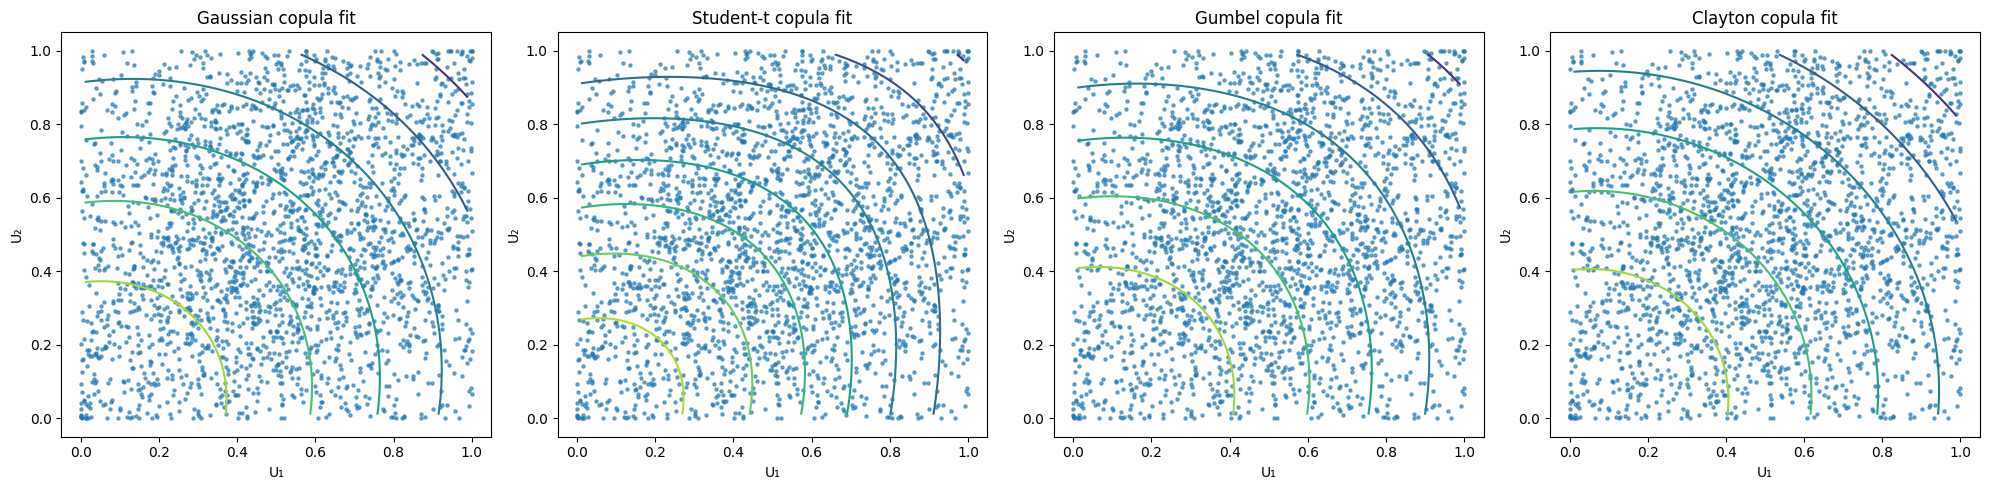

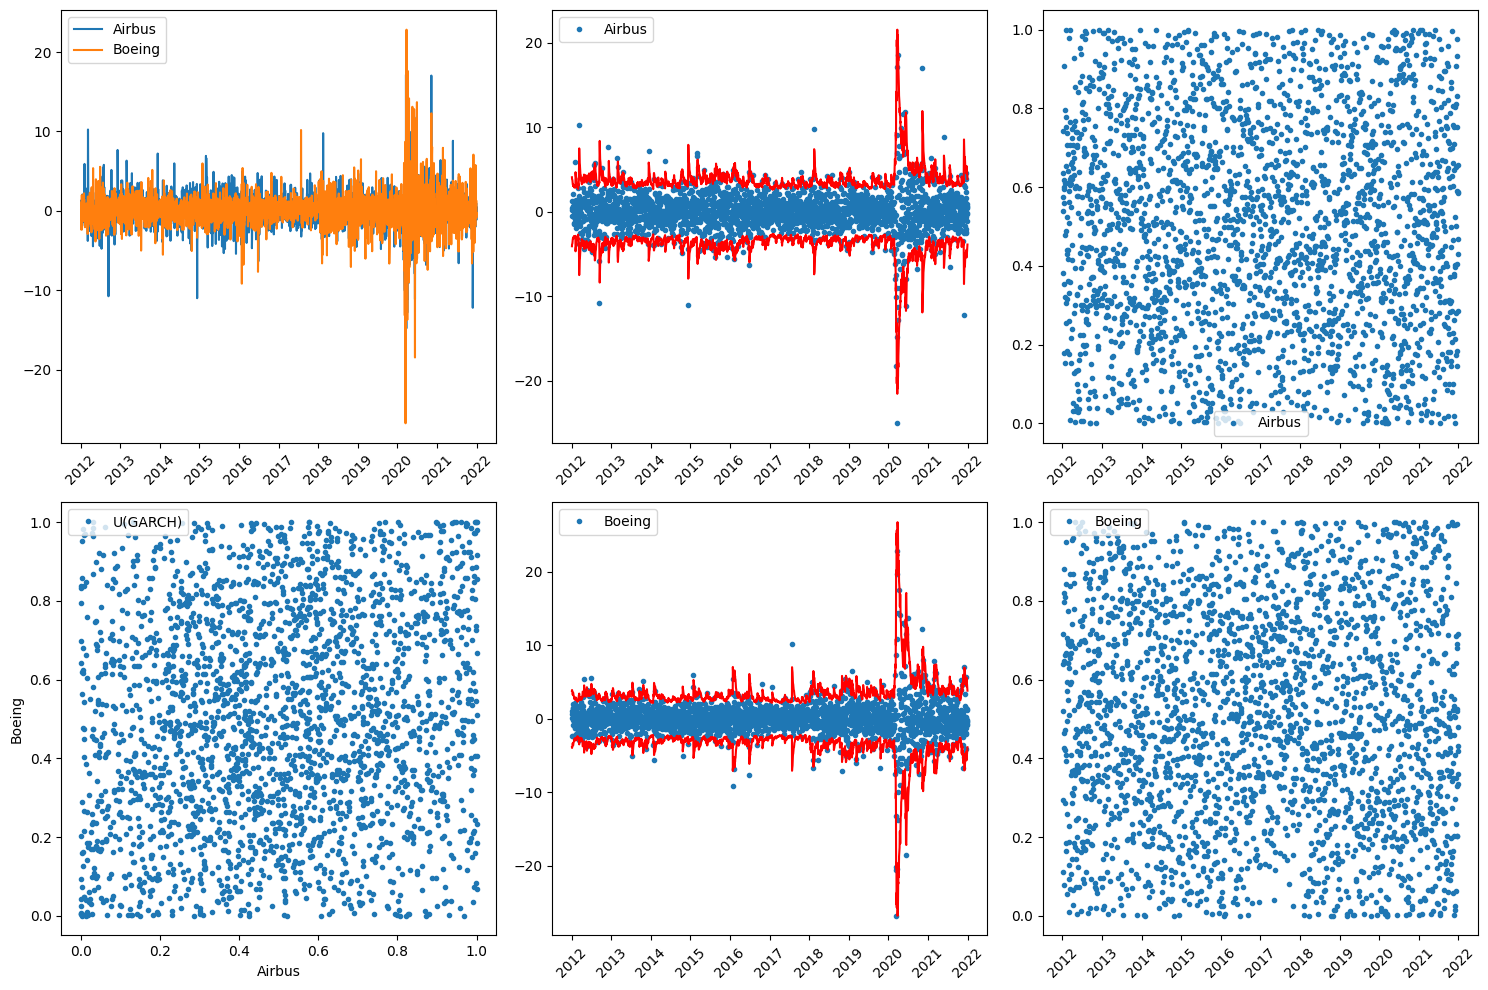

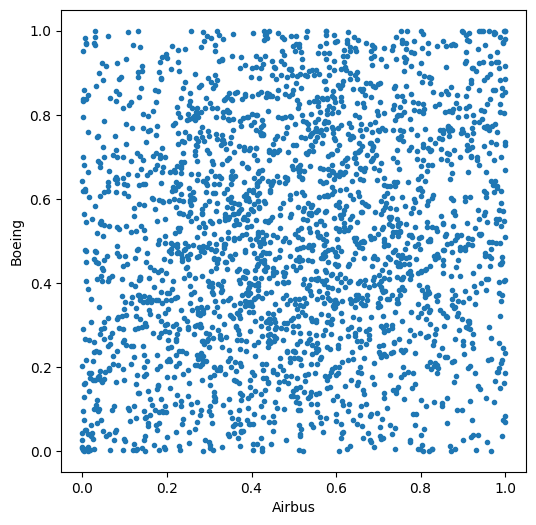

Estimation results:
\begin{tabular}{lrrr}
\toprule
 & Corr & Norm & t \\
\midrule
Rho & 0.143 & 0.143 & 0.143 \\
Nu & NaN & NaN & 3.000 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrr}
\toprule
 & GuTau & gumbel & gumbelSM & ClTau & clayton & claytonSM \\
\midrule
Theta & 1.103 & 1.103 & 1.103 & 0.206 & 0.130 & 0.130 \\
LL & NaN & -inf & -inf & NaN & 27.949 & 27.949 \\
\bottomrule
\end{tabular}



In [48]:
main(df_pair2)


=====
Estimating model for "C_NVIDIA"
Hallo
Initial LL=-6006.06 in EstGASTr

=====
Estimating model for "C_ASML"
Hallo
Initial LL=-5187.03 in EstGASTr
Kendall's tau = 0.2075045742961612
Spearman's rho = 0.30318303691754434
            U_NVIDIA    U_ASML
Date                          
5/1/2012    0.785315  0.360636
6/1/2012    0.240320  0.676467
9/1/2012    0.530513  0.678672
10/1/2012   0.408958  0.533163
11/1/2012   0.102982  0.690368
...              ...       ...
27/12/2021  0.938867  0.770036
28/12/2021  0.219328  0.544583
29/12/2021  0.378609  0.137044
30/12/2021  0.249224  0.692140
31/12/2021  0.442282  0.349951

[2533 rows x 2 columns]

BFGS results in  NaN result encountered. 
Pars:  [0.3133281] 
LL=  nan , f-eval=  2

BFGS results in  NaN result encountered. 
Pars:  [0.3133281 3.       ] 
LL=  nan , f-eval=  3
l: -inf, th: 1.2618
l: -inf, th: 1.2618

BFGS results in  NaN result encountered. 
Pars:  [1.26183694] 
LL=  -inf , f-eval=  2

BFGS results in  NaN result encountered.

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_34041/200518462.py:313: RuntimeWarning: invalid value encountered in subtract
  vLL= vF - vG
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_34041/200518462.py:313: RuntimeWarning: invalid value encountered in subtract
  vLL= vF - vG
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stat

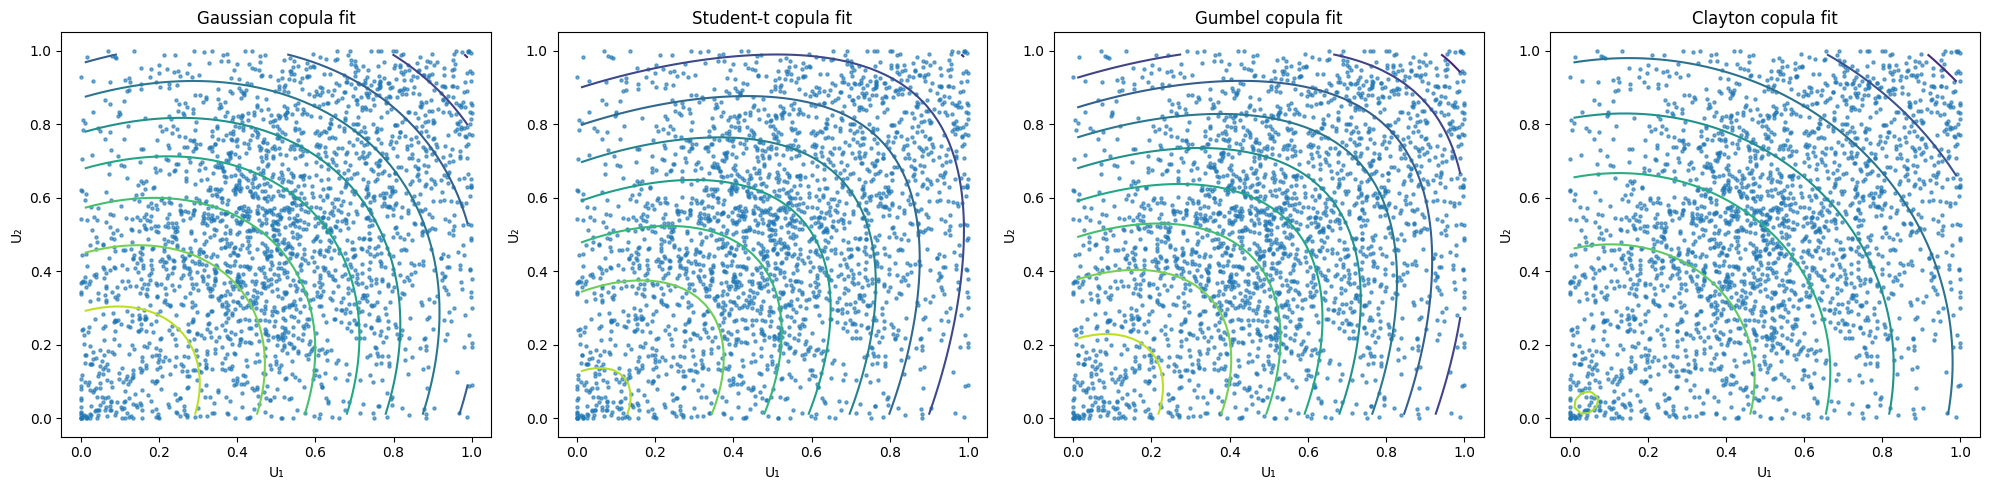

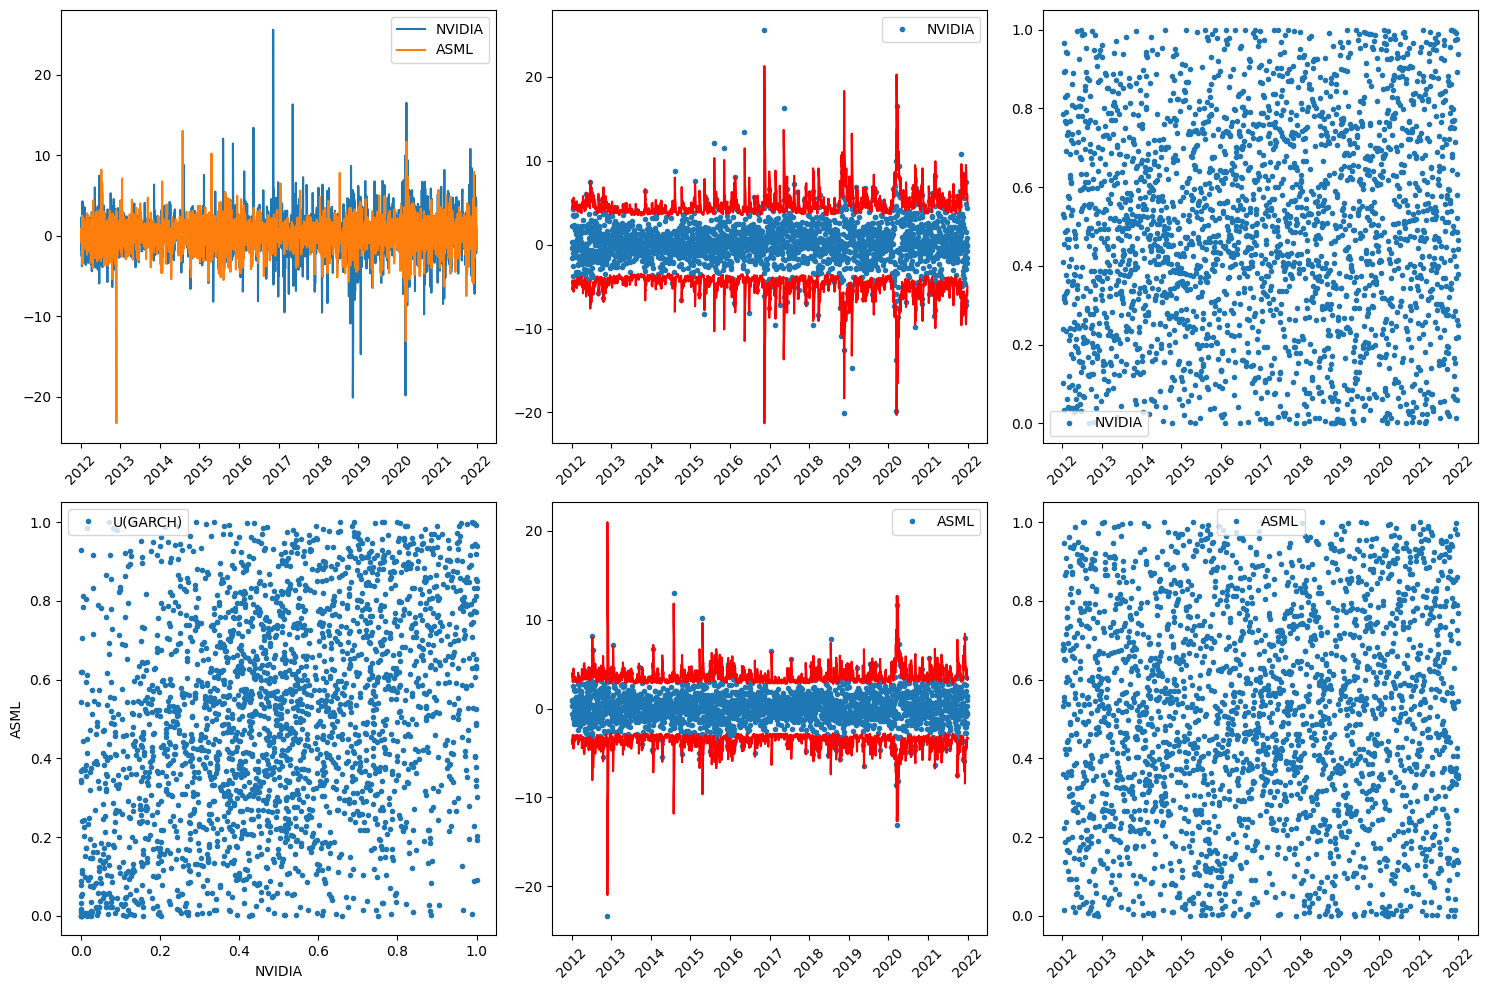

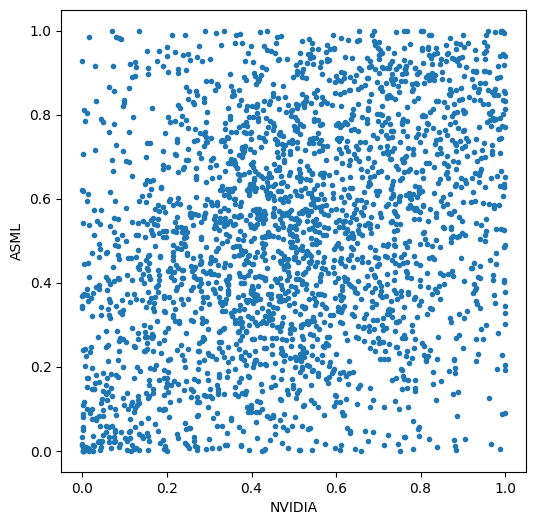

Estimation results:
\begin{tabular}{lrrr}
\toprule
 & Corr & Norm & t \\
\midrule
Rho & 0.313 & 0.313 & 0.313 \\
Nu & NaN & NaN & 3.000 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrr}
\toprule
 & GuTau & gumbel & gumbelSM & ClTau & clayton & claytonSM \\
\midrule
Theta & 1.262 & 1.262 & 1.262 & 0.524 & 0.281 & 0.281 \\
LL & NaN & -inf & -inf & NaN & 84.660 & 84.660 \\
\bottomrule
\end{tabular}



In [49]:
main(df_pair3)